In [1]:
import math
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

!nvidia-smi

Wed Jun 14 09:19:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:16:00.0 Off |                    0 |
| N/A   34C    P0    52W / 300W |    921MiB / 32768MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Dispositivo onde tensores serão criados, armazenados e processados
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Randon Seed fixa para resultados reprodutíveis
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

cuda:0


## Data Loader

In [3]:
class WellLoader(Dataset):
    
    def __init__(self, 
                 path, 
                 wells, 
                 var_in, 
                 var_out,
                 normalizing_percentile=90.0,
                 normalizing_split=0.2,
                 normalizer=RobustScaler,
                 max_sequence=16, 
                 step=1):
        
        self.path = path
        with open(self.path + '/metadata.json', 'r') as metafile:
            self.metadata = json.loads(metafile.read())
        self.wells = wells
        self.var_in = var_in
        self.var_out = var_out
        self.normalizing_percentile=normalizing_percentile
        self.normalizing_split = normalizing_split
        self.normalizer = normalizer
        self.max_sequence = max_sequence
        self.step = step
        self.batches_X = None
        self.batches_Y = None
        self.outputs = None
        self.normalizers = []
        
        indexes = self.get_wells_index(self.wells)
        self.load_data_by_index(indexes)
        
    def get_wells_index(self, wells):
        
        indexes = []
        for well, filt in wells:
            indexes.extend([(meta['INDEX'], filt) for meta in self.metadata if meta['WELL'] == well])
        return indexes
    
    def load_data_by_index(self, indexes):
        
        batches_X = []
        batches_Y = []
        outputs = []
        for index, filt in indexes:
            data = pd.read_json(f'{self.path}/{index}.json')#.reset_index()
            # Armengue: Por liq vol para preencher o dataset
            data['BORE_LIQ_VOL'] = data['BORE_OIL_VOL'] + data['BORE_WAT_VOL']
            data = data[self.var_in + self.var_out].dropna().reset_index(drop=True)
            X = data[self.var_in].values[filt,:]
            Y = data[self.var_out].values[filt,:]
            X_base, _, Y_base, _ = train_test_split(X, Y, test_size = self.normalizing_split)
            #scaler_X = X_base.max(axis=0, keepdims=True)
            #scaler_Y = Y_base.max(axis=0, keepdims=True)
            #scaler_X = self.normalizer().fit(X_base)
            #scaler_Y = self.normalizer().fit(Y_base)
            scaler_X = np.percentile(X_base,self.normalizing_percentile,axis=0,keepdims=True)
            scaler_Y = np.percentile(Y_base,self.normalizing_percentile,axis=0,keepdims=True)
            self.normalizers.append((scaler_X, scaler_Y))
            #X, Y = scaler_X.transform(X), scaler_Y.transform(Y)
            X, Y = X / scaler_X, Y / scaler_Y
            X, Y = torch.from_numpy(X.astype('float32')), torch.from_numpy(Y.astype('float32'))
            output = Y[self.max_sequence::self.step]
            #print(Y.shape)
            #X = torch.split(X, self.max_sequence, dim= 0)
            #Y = torch.split(Y, self.max_sequence, dim= 0)
            X = X.unfold(0,self.max_sequence, self.step)
            Y = Y.unfold(0,self.max_sequence, self.step)
            batches_X.append(X)
            batches_Y.append(Y)
            outputs.append(output)
            #print(X.shape)
        self.batches_X = torch.concat(batches_X, axis=0)
        self.batches_Y = torch.concat(batches_Y, axis=0)
        self.outputs = torch.concat(outputs, axis=0)
            
    def __len__(self):
        
        return self.outputs.shape[0]
    
    def __getitem__(self, idx):
                        
        srcs = self.batches_X[idx,:,:]
        trgts = self.batches_Y[idx,:,:]
        output = self.outputs[idx,:]
        
        return srcs, trgts, output
        
        
                 

In [4]:
path = './dataset/volve'
wells = [
    ('15/9-F-1 C', slice(28, None)),
]

var_in = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_CHOKE_SIZE_P',
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

var_out = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]


dataset = WellLoader(path, wells, var_in, var_out, max_sequence = 8)

In [5]:
class SubsetSplitter:
    
    def __init__(self, batch_size, validation_split, test_split, shuffle=False):
        
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.test_split = test_split
        self.shuffle = shuffle
        
    def __call__(self, dataset:Dataset):
        
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        validation_split = int(np.floor(self.validation_split * dataset_size))
        test_split = int(np.floor(self.test_split * dataset_size))
        train_split = dataset_size - validation_split - test_split
        # Extracting test independently of others
        test_indices = indices[train_split + validation_split:]
        indices = indices[:train_split + validation_split]
        if self.shuffle :
            np.random.shuffle(indices)
        train_indices = indices[:train_split]
        validation_indices = indices[train_split:]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(validation_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, 
                                                   sampler=train_sampler)
        validation_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                    sampler=valid_sampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                    sampler=test_sampler)
        
        return train_loader, validation_loader, test_loader

In [6]:
splitter = SubsetSplitter(4, 0.1, 0.3, shuffle=False)
train_loader, validation_loader, test_loader = splitter(dataset)

## Model definition

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    
    
positional_encoding = PositionalEncoding(dim_model = 10, dropout_p=0.3, max_len=1200)
tensor = torch.zeros((1,2,10))
tensor
encoded = positional_encoding(tensor)
encoded

tensor([[[0.0000, 0.0000, 0.0000, 1.4286, 0.0000, 1.4286, 0.0000, 1.4286,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4286, 0.0000, 0.0000,
          0.0000, 1.4286]]])

In [8]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_outputs,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
        dim_feedforward =2048,
        num_linear_layers=0,
        norm_first=False
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        #self.embedding = nn.Embedding(num_outputs, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p, 
            batch_first=True,
            norm_first = norm_first,
            dim_feedforward =dim_feedforward 
        )
        self.linear_layers = nn.ModuleList()
        for i in range(num_linear_layers):
            self.linear_layers.append(nn.Linear(dim_model, dim_model))
            self.linear_layers.append(nn.ReLU6())
        self.out = nn.Linear(dim_model, num_outputs)
        #self.bias_layer = nn.Linear(dim_model, dim_model)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        #src = self.embedding(src) * math.sqrt(self.dim_model)
        #tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src_corr = src #* math.sqrt(self.dim_model)
        tgt_corr = tgt #* math.sqrt(self.dim_model)
        #src_corr = self.positional_encoder(src_corr)
        #tgt_corr = self.positional_encoder(tgt_corr)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        #src = src.permute(1,0,2)
        #tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src_corr, tgt_corr, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, 
                                           tgt_key_padding_mask=tgt_pad_mask)
        for linear in self.linear_layers:
            transformer_out = linear(transformer_out)
        out = transformer_out
        out = torch.add(out, tgt)
        
        #recuperando informacao de escala
        #out = torch.mul(out, tgt)
        #bias = self.bias_layer(tgt)
        #out = torch.add(out, bias)
        
        out = self.out(out)
        
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [9]:
class Training:
    
    def __init__(self, epochs, loss, optimizer, scheduler, path, model_name='Transformer', early_stop=True, patience=5):
        
        self.loss = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.path = path
        self.model_name = model_name
        self.early_stop_flag = early_stop
        self.patience = patience
        self.clear_results()
        
    def clear_results(self):
        
        self.results = {
            'Train':[],
            'Validation':[],
            'Test':[],
        }
        
    def fit(self, model, train_loader, validation_loader, test_loader):
        
        self.clear_results()
        torch.cuda.empty_cache()
        decrease = self.patience
        not_improved = 0
        
        model.to(device)
        fit_time = time.time()
        
        for e in range(self.epochs):
            since = time.time()
            running_loss = 0
            #training loop
            model.train()
            self.train_loop(model, train_loader)
            model.eval()
            self.validation_loop(model, validation_loader)
            self.test_loop(model, test_loader)
            decrease, not_improved = self.early_stopping(validation_loader, decrease)
            if not_improved == 1 and self.early_stop_flag:
                print('[***] end training ...') 
                break
            loss_per_training_batch = self.results['Train'][-1]
            loss_per_validation_batch = self.results['Validation'][-1]
            loss_per_test_batch = self.results['Test'][-1]
            print("Epoch:{}/{}..".format(e+1, self.epochs),
                  "Train Loss: {:.3f}..".format(loss_per_training_batch),
                  "Val Loss: {:.3f}..".format(loss_per_validation_batch),
                  "Test Loss: {:.3f}..".format(loss_per_test_batch),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
        
    def train_loop(self, model, train_loader):
        
        running_loss = 0.0
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            X, y_tgt, y_out = data
            X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
            #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
            #y_tgt[:,:,1:] = Y[:,:,:-1]
            #y_tgt[:,:,0] = 0.0
            output = model(X, y_tgt)
            loss = self.loss(output.ravel(), y_out.ravel())
            #backward
            loss.backward()
            self.optimizer.step() #update weight          
            self.optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            if not self.scheduler is None:
                self.scheduler.step()
            running_loss += loss.item()
        
        self.results['Train'].append(running_loss/len(train_loader))
    
    
    def validation_loop(self, model, validation_loader):
        
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(validation_loader)):
                #training phase
                X, y_tgt, y_out = data
                X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
                #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
                #y_tgt[:,:,1:] = Y[:,:,:-1]
                #y_tgt[:,:,0] = 0.0
                output = model(X, y_tgt)
                loss = self.loss(output.ravel(), y_out.ravel())
                
                running_loss += loss.item()
        
        self.results['Validation'].append(running_loss/len(validation_loader))
        
    def test_loop(self, model, test_loader):
        
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(test_loader)):
                #training phase
                X, y_tgt, y_out = data
                X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
                #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
                #y_tgt[:,:,1:] = Y[:,:,:-1]
                #y_tgt[:,:,0] = 0.0
                output = model(X, y_tgt)
                loss = self.loss(output.ravel(), y_out.ravel())
                
                running_loss += loss.item()
        
        self.results['Test'].append(running_loss/len(test_loader))
        
    def early_stopping(self, validation_loader, decrease):
        
        loss_per_validation_batch = self.results['Validation'][-1]
        min_loss = np.min(self.results['Validation'][:-1] + [np.inf])
        if min_loss >= self.results['Validation'][-1]:
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, loss_per_validation_batch))
            decrease = self.patience
            print('saving model...')
            torch.save(model, self.path + f'/{self.model_name}.pt')
        else:
            decrease -= 1
        if decrease < 0:     
                not_improved = 1
        else:
            not_improved = 0
        return decrease, not_improved
    
    def get_best_model(self):
        
        model = torch.load(self.path + f'/{self.model_name}.pt')
        return model
            
            

In [10]:
model = Transformer(
    num_outputs=1, dim_model=dataset.max_sequence, num_heads=2, 
    num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1, norm_first=False,
    num_linear_layers=0, dim_feedforward =4*dataset.max_sequence
).to(device)

print(model)

lr_ = 5e-4
epoch = 1000
weight_decay = 1e-4
path = '.'
model_name = 'ADIM-RATIO'

loss = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr_)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weight_decay)
sched = None
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr_, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
training = Training(epoch, loss, optimizer, sched, model_name=model_name, path=path, early_stop=False, patience=20)

Transformer(
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (linear1): Linear(in_features=8, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=32, out_features=8, bias=True)
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2

In [11]:
training.fit(model, train_loader, validation_loader, test_loader)
best_model = training.get_best_model()

100%|██████████| 53/53 [00:00<00:00, 327.25it/s]


Loss Decreasing.. inf >> 0.192 
saving model...
Epoch:1/1000.. Train Loss: 0.305.. Val Loss: 0.192.. Test Loss: 0.153.. Time: 0.04m


100%|██████████| 53/53 [00:00<00:00, 326.36it/s]


Loss Decreasing.. 0.192 >> 0.170 
saving model...
Epoch:2/1000.. Train Loss: 0.235.. Val Loss: 0.170.. Test Loss: 0.142.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.00it/s]


Loss Decreasing.. 0.170 >> 0.154 
saving model...
Epoch:3/1000.. Train Loss: 0.218.. Val Loss: 0.154.. Test Loss: 0.132.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.82it/s]


Loss Decreasing.. 0.154 >> 0.153 
saving model...
Epoch:4/1000.. Train Loss: 0.175.. Val Loss: 0.153.. Test Loss: 0.124.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.11it/s]


Loss Decreasing.. 0.153 >> 0.142 
saving model...
Epoch:5/1000.. Train Loss: 0.212.. Val Loss: 0.142.. Test Loss: 0.120.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.33it/s]


Loss Decreasing.. 0.142 >> 0.138 
saving model...
Epoch:6/1000.. Train Loss: 0.180.. Val Loss: 0.138.. Test Loss: 0.113.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.98it/s]


Loss Decreasing.. 0.138 >> 0.134 
saving model...
Epoch:7/1000.. Train Loss: 0.192.. Val Loss: 0.134.. Test Loss: 0.110.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.97it/s]


Loss Decreasing.. 0.134 >> 0.132 
saving model...
Epoch:8/1000.. Train Loss: 0.156.. Val Loss: 0.132.. Test Loss: 0.106.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 314.00it/s]


Loss Decreasing.. 0.132 >> 0.128 
saving model...
Epoch:9/1000.. Train Loss: 0.154.. Val Loss: 0.128.. Test Loss: 0.103.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.20it/s]


Loss Decreasing.. 0.128 >> 0.127 
saving model...
Epoch:10/1000.. Train Loss: 0.164.. Val Loss: 0.127.. Test Loss: 0.098.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.81it/s]


Epoch:11/1000.. Train Loss: 0.144.. Val Loss: 0.129.. Test Loss: 0.096.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.05it/s]


Loss Decreasing.. 0.127 >> 0.123 
saving model...
Epoch:12/1000.. Train Loss: 0.154.. Val Loss: 0.123.. Test Loss: 0.093.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 313.67it/s]


Loss Decreasing.. 0.123 >> 0.120 
saving model...
Epoch:13/1000.. Train Loss: 0.168.. Val Loss: 0.120.. Test Loss: 0.092.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.94it/s]


Epoch:14/1000.. Train Loss: 0.149.. Val Loss: 0.125.. Test Loss: 0.092.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 311.05it/s]


Epoch:15/1000.. Train Loss: 0.121.. Val Loss: 0.121.. Test Loss: 0.089.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 321.64it/s]


Epoch:16/1000.. Train Loss: 0.127.. Val Loss: 0.127.. Test Loss: 0.087.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.36it/s]


Loss Decreasing.. 0.120 >> 0.117 
saving model...
Epoch:17/1000.. Train Loss: 0.127.. Val Loss: 0.117.. Test Loss: 0.085.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.17it/s]


Epoch:18/1000.. Train Loss: 0.124.. Val Loss: 0.127.. Test Loss: 0.084.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 282.57it/s]


Epoch:19/1000.. Train Loss: 0.117.. Val Loss: 0.120.. Test Loss: 0.084.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.40it/s]


Loss Decreasing.. 0.117 >> 0.112 
saving model...
Epoch:20/1000.. Train Loss: 0.107.. Val Loss: 0.112.. Test Loss: 0.082.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.46it/s]


Loss Decreasing.. 0.112 >> 0.111 
saving model...
Epoch:21/1000.. Train Loss: 0.120.. Val Loss: 0.111.. Test Loss: 0.080.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.17it/s]


Epoch:22/1000.. Train Loss: 0.118.. Val Loss: 0.112.. Test Loss: 0.080.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.22it/s]


Loss Decreasing.. 0.111 >> 0.110 
saving model...
Epoch:23/1000.. Train Loss: 0.117.. Val Loss: 0.110.. Test Loss: 0.078.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.09it/s]


Loss Decreasing.. 0.110 >> 0.108 
saving model...
Epoch:24/1000.. Train Loss: 0.114.. Val Loss: 0.108.. Test Loss: 0.076.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.78it/s]


Epoch:25/1000.. Train Loss: 0.105.. Val Loss: 0.113.. Test Loss: 0.075.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.76it/s]


Loss Decreasing.. 0.108 >> 0.108 
saving model...
Epoch:26/1000.. Train Loss: 0.101.. Val Loss: 0.108.. Test Loss: 0.076.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.58it/s]


Epoch:27/1000.. Train Loss: 0.104.. Val Loss: 0.111.. Test Loss: 0.074.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.76it/s]


Epoch:28/1000.. Train Loss: 0.100.. Val Loss: 0.111.. Test Loss: 0.073.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.55it/s]


Loss Decreasing.. 0.108 >> 0.107 
saving model...
Epoch:29/1000.. Train Loss: 0.104.. Val Loss: 0.107.. Test Loss: 0.071.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.09it/s]


Loss Decreasing.. 0.107 >> 0.106 
saving model...
Epoch:30/1000.. Train Loss: 0.102.. Val Loss: 0.106.. Test Loss: 0.070.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.70it/s]


Epoch:31/1000.. Train Loss: 0.099.. Val Loss: 0.123.. Test Loss: 0.070.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.23it/s]


Epoch:32/1000.. Train Loss: 0.102.. Val Loss: 0.106.. Test Loss: 0.069.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.52it/s]


Loss Decreasing.. 0.106 >> 0.104 
saving model...
Epoch:33/1000.. Train Loss: 0.092.. Val Loss: 0.104.. Test Loss: 0.067.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.25it/s]


Epoch:34/1000.. Train Loss: 0.095.. Val Loss: 0.108.. Test Loss: 0.067.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.14it/s]


Epoch:35/1000.. Train Loss: 0.090.. Val Loss: 0.110.. Test Loss: 0.066.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.29it/s]


Loss Decreasing.. 0.104 >> 0.104 
saving model...
Epoch:36/1000.. Train Loss: 0.090.. Val Loss: 0.104.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.19it/s]


Epoch:37/1000.. Train Loss: 0.081.. Val Loss: 0.105.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.32it/s]


Loss Decreasing.. 0.104 >> 0.103 
saving model...
Epoch:38/1000.. Train Loss: 0.091.. Val Loss: 0.103.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.57it/s]


Epoch:39/1000.. Train Loss: 0.076.. Val Loss: 0.105.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.08it/s]


Epoch:40/1000.. Train Loss: 0.082.. Val Loss: 0.108.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.06it/s]


Loss Decreasing.. 0.103 >> 0.100 
saving model...
Epoch:41/1000.. Train Loss: 0.087.. Val Loss: 0.100.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.68it/s]


Epoch:42/1000.. Train Loss: 0.082.. Val Loss: 0.102.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.09it/s]


Loss Decreasing.. 0.100 >> 0.098 
saving model...
Epoch:43/1000.. Train Loss: 0.080.. Val Loss: 0.098.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.38it/s]


Epoch:44/1000.. Train Loss: 0.075.. Val Loss: 0.100.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.09it/s]


Epoch:45/1000.. Train Loss: 0.083.. Val Loss: 0.100.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.10it/s]


Loss Decreasing.. 0.098 >> 0.098 
saving model...
Epoch:46/1000.. Train Loss: 0.080.. Val Loss: 0.098.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.55it/s]


Loss Decreasing.. 0.098 >> 0.097 
saving model...
Epoch:47/1000.. Train Loss: 0.080.. Val Loss: 0.097.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.17it/s]


Epoch:48/1000.. Train Loss: 0.071.. Val Loss: 0.100.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.91it/s]


Epoch:49/1000.. Train Loss: 0.073.. Val Loss: 0.099.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.31it/s]


Loss Decreasing.. 0.097 >> 0.096 
saving model...
Epoch:50/1000.. Train Loss: 0.071.. Val Loss: 0.096.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.51it/s]


Epoch:51/1000.. Train Loss: 0.066.. Val Loss: 0.098.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.93it/s]


Epoch:52/1000.. Train Loss: 0.067.. Val Loss: 0.102.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.58it/s]


Epoch:53/1000.. Train Loss: 0.067.. Val Loss: 0.097.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.98it/s]


Loss Decreasing.. 0.096 >> 0.095 
saving model...
Epoch:54/1000.. Train Loss: 0.063.. Val Loss: 0.095.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.91it/s]


Epoch:55/1000.. Train Loss: 0.073.. Val Loss: 0.097.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.03it/s]


Loss Decreasing.. 0.095 >> 0.094 
saving model...
Epoch:56/1000.. Train Loss: 0.068.. Val Loss: 0.094.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 336.32it/s]


Epoch:57/1000.. Train Loss: 0.067.. Val Loss: 0.096.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 336.82it/s]


Epoch:58/1000.. Train Loss: 0.066.. Val Loss: 0.094.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.43it/s]


Epoch:59/1000.. Train Loss: 0.063.. Val Loss: 0.094.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.26it/s]


Loss Decreasing.. 0.094 >> 0.093 
saving model...
Epoch:60/1000.. Train Loss: 0.063.. Val Loss: 0.093.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.53it/s]


Epoch:61/1000.. Train Loss: 0.063.. Val Loss: 0.095.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.62it/s]


Loss Decreasing.. 0.093 >> 0.093 
saving model...
Epoch:62/1000.. Train Loss: 0.062.. Val Loss: 0.093.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.90it/s]


Epoch:63/1000.. Train Loss: 0.058.. Val Loss: 0.102.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.25it/s]


Loss Decreasing.. 0.093 >> 0.092 
saving model...
Epoch:64/1000.. Train Loss: 0.063.. Val Loss: 0.092.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.51it/s]


Loss Decreasing.. 0.092 >> 0.091 
saving model...
Epoch:65/1000.. Train Loss: 0.059.. Val Loss: 0.091.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.54it/s]


Epoch:66/1000.. Train Loss: 0.057.. Val Loss: 0.093.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.94it/s]


Loss Decreasing.. 0.091 >> 0.090 
saving model...
Epoch:67/1000.. Train Loss: 0.060.. Val Loss: 0.090.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.84it/s]


Epoch:68/1000.. Train Loss: 0.061.. Val Loss: 0.091.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 314.40it/s]


Loss Decreasing.. 0.090 >> 0.088 
saving model...
Epoch:69/1000.. Train Loss: 0.056.. Val Loss: 0.088.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.75it/s]


Epoch:70/1000.. Train Loss: 0.053.. Val Loss: 0.091.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.22it/s]


Loss Decreasing.. 0.088 >> 0.087 
saving model...
Epoch:71/1000.. Train Loss: 0.055.. Val Loss: 0.087.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.36it/s]


Loss Decreasing.. 0.087 >> 0.087 
saving model...
Epoch:72/1000.. Train Loss: 0.055.. Val Loss: 0.087.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 336.02it/s]


Epoch:73/1000.. Train Loss: 0.053.. Val Loss: 0.091.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 318.77it/s]


Loss Decreasing.. 0.087 >> 0.085 
saving model...
Epoch:74/1000.. Train Loss: 0.050.. Val Loss: 0.085.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.52it/s]


Epoch:75/1000.. Train Loss: 0.053.. Val Loss: 0.091.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.99it/s]


Epoch:76/1000.. Train Loss: 0.051.. Val Loss: 0.085.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.91it/s]


Epoch:77/1000.. Train Loss: 0.057.. Val Loss: 0.087.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.61it/s]


Loss Decreasing.. 0.085 >> 0.085 
saving model...
Epoch:78/1000.. Train Loss: 0.049.. Val Loss: 0.085.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.17it/s]


Epoch:79/1000.. Train Loss: 0.046.. Val Loss: 0.085.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.73it/s]


Loss Decreasing.. 0.085 >> 0.085 
saving model...
Epoch:80/1000.. Train Loss: 0.048.. Val Loss: 0.085.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.38it/s]


Epoch:81/1000.. Train Loss: 0.049.. Val Loss: 0.086.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.39it/s]


Loss Decreasing.. 0.085 >> 0.082 
saving model...
Epoch:82/1000.. Train Loss: 0.046.. Val Loss: 0.082.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.93it/s]


Epoch:83/1000.. Train Loss: 0.051.. Val Loss: 0.084.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.25it/s]


Epoch:84/1000.. Train Loss: 0.050.. Val Loss: 0.090.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.88it/s]


Loss Decreasing.. 0.082 >> 0.081 
saving model...
Epoch:85/1000.. Train Loss: 0.048.. Val Loss: 0.081.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 361.74it/s]


Epoch:86/1000.. Train Loss: 0.047.. Val Loss: 0.083.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.00it/s]


Loss Decreasing.. 0.081 >> 0.080 
saving model...
Epoch:87/1000.. Train Loss: 0.051.. Val Loss: 0.080.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.21it/s]


Epoch:88/1000.. Train Loss: 0.048.. Val Loss: 0.081.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.48it/s]


Epoch:89/1000.. Train Loss: 0.045.. Val Loss: 0.082.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.94it/s]


Epoch:90/1000.. Train Loss: 0.046.. Val Loss: 0.080.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.75it/s]


Epoch:91/1000.. Train Loss: 0.046.. Val Loss: 0.080.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.75it/s]


Epoch:92/1000.. Train Loss: 0.047.. Val Loss: 0.081.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.27it/s]


Loss Decreasing.. 0.080 >> 0.079 
saving model...
Epoch:93/1000.. Train Loss: 0.043.. Val Loss: 0.079.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.48it/s]


Loss Decreasing.. 0.079 >> 0.076 
saving model...
Epoch:94/1000.. Train Loss: 0.043.. Val Loss: 0.076.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.23it/s]


Loss Decreasing.. 0.076 >> 0.075 
saving model...
Epoch:95/1000.. Train Loss: 0.044.. Val Loss: 0.075.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.10it/s]


Loss Decreasing.. 0.075 >> 0.075 
saving model...
Epoch:96/1000.. Train Loss: 0.042.. Val Loss: 0.075.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.78it/s]


Loss Decreasing.. 0.075 >> 0.074 
saving model...
Epoch:97/1000.. Train Loss: 0.043.. Val Loss: 0.074.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.66it/s]


Epoch:98/1000.. Train Loss: 0.045.. Val Loss: 0.076.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.56it/s]


Epoch:99/1000.. Train Loss: 0.044.. Val Loss: 0.077.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.02it/s]


Epoch:100/1000.. Train Loss: 0.039.. Val Loss: 0.079.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.33it/s]


Epoch:101/1000.. Train Loss: 0.043.. Val Loss: 0.078.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.08it/s]


Loss Decreasing.. 0.074 >> 0.074 
saving model...
Epoch:102/1000.. Train Loss: 0.045.. Val Loss: 0.074.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.74it/s]


Loss Decreasing.. 0.074 >> 0.073 
saving model...
Epoch:103/1000.. Train Loss: 0.041.. Val Loss: 0.073.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 336.22it/s]


Epoch:104/1000.. Train Loss: 0.039.. Val Loss: 0.078.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.40it/s]


Epoch:105/1000.. Train Loss: 0.043.. Val Loss: 0.074.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.74it/s]


Epoch:106/1000.. Train Loss: 0.041.. Val Loss: 0.076.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.36it/s]


Epoch:107/1000.. Train Loss: 0.039.. Val Loss: 0.074.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.09it/s]


Loss Decreasing.. 0.073 >> 0.072 
saving model...
Epoch:108/1000.. Train Loss: 0.039.. Val Loss: 0.072.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 313.49it/s]


Epoch:109/1000.. Train Loss: 0.037.. Val Loss: 0.073.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.28it/s]


Epoch:110/1000.. Train Loss: 0.042.. Val Loss: 0.072.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.46it/s]


Epoch:111/1000.. Train Loss: 0.040.. Val Loss: 0.072.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.60it/s]


Loss Decreasing.. 0.072 >> 0.071 
saving model...
Epoch:112/1000.. Train Loss: 0.037.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.63it/s]


Loss Decreasing.. 0.071 >> 0.071 
saving model...
Epoch:113/1000.. Train Loss: 0.039.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.68it/s]


Epoch:114/1000.. Train Loss: 0.036.. Val Loss: 0.078.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.14it/s]


Epoch:115/1000.. Train Loss: 0.039.. Val Loss: 0.073.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.21it/s]


Epoch:116/1000.. Train Loss: 0.038.. Val Loss: 0.081.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.12it/s]


Epoch:117/1000.. Train Loss: 0.036.. Val Loss: 0.073.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.86it/s]


Epoch:118/1000.. Train Loss: 0.039.. Val Loss: 0.072.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.94it/s]


Loss Decreasing.. 0.071 >> 0.071 
saving model...
Epoch:119/1000.. Train Loss: 0.036.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.47it/s]


Epoch:120/1000.. Train Loss: 0.037.. Val Loss: 0.071.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.03it/s]


Epoch:121/1000.. Train Loss: 0.034.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.05it/s]


Epoch:122/1000.. Train Loss: 0.036.. Val Loss: 0.072.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.31it/s]


Epoch:123/1000.. Train Loss: 0.034.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.22it/s]


Epoch:124/1000.. Train Loss: 0.036.. Val Loss: 0.072.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.10it/s]


Loss Decreasing.. 0.071 >> 0.069 
saving model...
Epoch:125/1000.. Train Loss: 0.035.. Val Loss: 0.069.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.55it/s]


Epoch:126/1000.. Train Loss: 0.035.. Val Loss: 0.070.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.65it/s]


Epoch:127/1000.. Train Loss: 0.037.. Val Loss: 0.073.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.40it/s]


Epoch:128/1000.. Train Loss: 0.034.. Val Loss: 0.075.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.41it/s]


Epoch:129/1000.. Train Loss: 0.035.. Val Loss: 0.073.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.21it/s]


Epoch:130/1000.. Train Loss: 0.036.. Val Loss: 0.076.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.73it/s]


Epoch:131/1000.. Train Loss: 0.033.. Val Loss: 0.073.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.80it/s]


Loss Decreasing.. 0.069 >> 0.069 
saving model...
Epoch:132/1000.. Train Loss: 0.035.. Val Loss: 0.069.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 320.87it/s]


Epoch:133/1000.. Train Loss: 0.035.. Val Loss: 0.069.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.81it/s]


Loss Decreasing.. 0.069 >> 0.068 
saving model...
Epoch:134/1000.. Train Loss: 0.035.. Val Loss: 0.068.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.11it/s]


Epoch:135/1000.. Train Loss: 0.032.. Val Loss: 0.070.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.32it/s]


Epoch:136/1000.. Train Loss: 0.033.. Val Loss: 0.085.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.72it/s]


Epoch:137/1000.. Train Loss: 0.035.. Val Loss: 0.069.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.41it/s]


Epoch:138/1000.. Train Loss: 0.034.. Val Loss: 0.070.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.27it/s]


Epoch:139/1000.. Train Loss: 0.036.. Val Loss: 0.075.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.52it/s]


Epoch:140/1000.. Train Loss: 0.033.. Val Loss: 0.068.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.56it/s]


Epoch:141/1000.. Train Loss: 0.033.. Val Loss: 0.069.. Test Loss: 0.040.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.23it/s]


Epoch:142/1000.. Train Loss: 0.034.. Val Loss: 0.074.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.22it/s]


Epoch:143/1000.. Train Loss: 0.031.. Val Loss: 0.068.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.04it/s]


Epoch:144/1000.. Train Loss: 0.030.. Val Loss: 0.068.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.87it/s]


Epoch:145/1000.. Train Loss: 0.033.. Val Loss: 0.069.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.56it/s]


Loss Decreasing.. 0.068 >> 0.068 
saving model...
Epoch:146/1000.. Train Loss: 0.032.. Val Loss: 0.068.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.36it/s]


Loss Decreasing.. 0.068 >> 0.067 
saving model...
Epoch:147/1000.. Train Loss: 0.033.. Val Loss: 0.067.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.98it/s]


Epoch:148/1000.. Train Loss: 0.031.. Val Loss: 0.072.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.21it/s]


Loss Decreasing.. 0.067 >> 0.066 
saving model...
Epoch:149/1000.. Train Loss: 0.030.. Val Loss: 0.066.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.04it/s]


Epoch:150/1000.. Train Loss: 0.034.. Val Loss: 0.071.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 311.82it/s]


Epoch:151/1000.. Train Loss: 0.030.. Val Loss: 0.070.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.94it/s]


Epoch:152/1000.. Train Loss: 0.032.. Val Loss: 0.068.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.58it/s]


Epoch:153/1000.. Train Loss: 0.032.. Val Loss: 0.069.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.43it/s]


Epoch:154/1000.. Train Loss: 0.033.. Val Loss: 0.071.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.91it/s]


Epoch:155/1000.. Train Loss: 0.033.. Val Loss: 0.077.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.86it/s]


Epoch:156/1000.. Train Loss: 0.031.. Val Loss: 0.067.. Test Loss: 0.040.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 298.83it/s]


Epoch:157/1000.. Train Loss: 0.032.. Val Loss: 0.067.. Test Loss: 0.040.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.52it/s]


Epoch:158/1000.. Train Loss: 0.030.. Val Loss: 0.069.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.03it/s]


Epoch:159/1000.. Train Loss: 0.032.. Val Loss: 0.066.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.39it/s]


Epoch:160/1000.. Train Loss: 0.031.. Val Loss: 0.068.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.36it/s]


Epoch:161/1000.. Train Loss: 0.032.. Val Loss: 0.072.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.59it/s]


Epoch:162/1000.. Train Loss: 0.032.. Val Loss: 0.080.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.07it/s]


Epoch:163/1000.. Train Loss: 0.031.. Val Loss: 0.085.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.91it/s]


Epoch:164/1000.. Train Loss: 0.031.. Val Loss: 0.069.. Test Loss: 0.040.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.89it/s]


Epoch:165/1000.. Train Loss: 0.031.. Val Loss: 0.069.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.13it/s]


Epoch:166/1000.. Train Loss: 0.030.. Val Loss: 0.069.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.96it/s]


Epoch:167/1000.. Train Loss: 0.030.. Val Loss: 0.075.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.74it/s]


Epoch:168/1000.. Train Loss: 0.030.. Val Loss: 0.069.. Test Loss: 0.040.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.78it/s]


Epoch:169/1000.. Train Loss: 0.031.. Val Loss: 0.070.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.84it/s]


Epoch:170/1000.. Train Loss: 0.031.. Val Loss: 0.079.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.64it/s]


Epoch:171/1000.. Train Loss: 0.031.. Val Loss: 0.067.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.72it/s]


Epoch:172/1000.. Train Loss: 0.031.. Val Loss: 0.069.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.89it/s]


Epoch:173/1000.. Train Loss: 0.030.. Val Loss: 0.068.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.91it/s]


Epoch:174/1000.. Train Loss: 0.030.. Val Loss: 0.086.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.59it/s]


Epoch:175/1000.. Train Loss: 0.028.. Val Loss: 0.067.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.80it/s]


Epoch:176/1000.. Train Loss: 0.029.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.19it/s]


Epoch:177/1000.. Train Loss: 0.030.. Val Loss: 0.069.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.69it/s]


Epoch:178/1000.. Train Loss: 0.030.. Val Loss: 0.068.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.70it/s]


Epoch:179/1000.. Train Loss: 0.029.. Val Loss: 0.072.. Test Loss: 0.041.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.80it/s]


Epoch:180/1000.. Train Loss: 0.029.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 340.08it/s]


Epoch:181/1000.. Train Loss: 0.031.. Val Loss: 0.074.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.21it/s]


Epoch:182/1000.. Train Loss: 0.031.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.22it/s]


Epoch:183/1000.. Train Loss: 0.029.. Val Loss: 0.069.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.22it/s]


Epoch:184/1000.. Train Loss: 0.028.. Val Loss: 0.072.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.61it/s]


Epoch:185/1000.. Train Loss: 0.029.. Val Loss: 0.071.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.92it/s]


Epoch:186/1000.. Train Loss: 0.029.. Val Loss: 0.069.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.90it/s]


Epoch:187/1000.. Train Loss: 0.030.. Val Loss: 0.070.. Test Loss: 0.042.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.10it/s]


Epoch:188/1000.. Train Loss: 0.028.. Val Loss: 0.071.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.83it/s]


Epoch:189/1000.. Train Loss: 0.028.. Val Loss: 0.075.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.76it/s]


Epoch:190/1000.. Train Loss: 0.031.. Val Loss: 0.071.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.01it/s]


Epoch:191/1000.. Train Loss: 0.028.. Val Loss: 0.071.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.55it/s]


Epoch:192/1000.. Train Loss: 0.029.. Val Loss: 0.069.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.14it/s]


Epoch:193/1000.. Train Loss: 0.029.. Val Loss: 0.081.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.71it/s]


Epoch:194/1000.. Train Loss: 0.030.. Val Loss: 0.072.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.81it/s]


Epoch:195/1000.. Train Loss: 0.029.. Val Loss: 0.070.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.95it/s]


Epoch:196/1000.. Train Loss: 0.028.. Val Loss: 0.072.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.30it/s]


Epoch:197/1000.. Train Loss: 0.028.. Val Loss: 0.072.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.74it/s]


Epoch:198/1000.. Train Loss: 0.029.. Val Loss: 0.069.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.97it/s]


Epoch:199/1000.. Train Loss: 0.029.. Val Loss: 0.069.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.49it/s]


Epoch:200/1000.. Train Loss: 0.027.. Val Loss: 0.073.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.15it/s]


Epoch:201/1000.. Train Loss: 0.028.. Val Loss: 0.072.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.97it/s]


Epoch:202/1000.. Train Loss: 0.027.. Val Loss: 0.073.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.65it/s]


Epoch:203/1000.. Train Loss: 0.029.. Val Loss: 0.071.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.07it/s]


Epoch:204/1000.. Train Loss: 0.028.. Val Loss: 0.074.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 321.21it/s]


Epoch:205/1000.. Train Loss: 0.029.. Val Loss: 0.072.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.70it/s]


Epoch:206/1000.. Train Loss: 0.028.. Val Loss: 0.071.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.28it/s]


Epoch:207/1000.. Train Loss: 0.028.. Val Loss: 0.071.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.03it/s]


Epoch:208/1000.. Train Loss: 0.028.. Val Loss: 0.073.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.61it/s]


Epoch:209/1000.. Train Loss: 0.028.. Val Loss: 0.073.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 311.99it/s]


Epoch:210/1000.. Train Loss: 0.028.. Val Loss: 0.082.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.67it/s]


Epoch:211/1000.. Train Loss: 0.028.. Val Loss: 0.069.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.06it/s]


Epoch:212/1000.. Train Loss: 0.029.. Val Loss: 0.078.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.99it/s]


Epoch:213/1000.. Train Loss: 0.029.. Val Loss: 0.069.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.80it/s]


Epoch:214/1000.. Train Loss: 0.028.. Val Loss: 0.070.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.13it/s]


Epoch:215/1000.. Train Loss: 0.029.. Val Loss: 0.069.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.88it/s]


Epoch:216/1000.. Train Loss: 0.027.. Val Loss: 0.069.. Test Loss: 0.043.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.94it/s]


Epoch:217/1000.. Train Loss: 0.028.. Val Loss: 0.071.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.25it/s]


Epoch:218/1000.. Train Loss: 0.030.. Val Loss: 0.072.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.52it/s]


Epoch:219/1000.. Train Loss: 0.029.. Val Loss: 0.079.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.86it/s]


Epoch:220/1000.. Train Loss: 0.029.. Val Loss: 0.069.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.60it/s]


Epoch:221/1000.. Train Loss: 0.027.. Val Loss: 0.070.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.03it/s]


Epoch:222/1000.. Train Loss: 0.027.. Val Loss: 0.070.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.87it/s]


Epoch:223/1000.. Train Loss: 0.027.. Val Loss: 0.076.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.02it/s]


Epoch:224/1000.. Train Loss: 0.027.. Val Loss: 0.074.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.17it/s]


Epoch:225/1000.. Train Loss: 0.027.. Val Loss: 0.072.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.92it/s]


Epoch:226/1000.. Train Loss: 0.027.. Val Loss: 0.070.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.20it/s]


Epoch:227/1000.. Train Loss: 0.026.. Val Loss: 0.071.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.88it/s]


Epoch:228/1000.. Train Loss: 0.027.. Val Loss: 0.071.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.85it/s]


Epoch:229/1000.. Train Loss: 0.025.. Val Loss: 0.077.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.06it/s]


Epoch:230/1000.. Train Loss: 0.027.. Val Loss: 0.073.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.38it/s]


Epoch:231/1000.. Train Loss: 0.024.. Val Loss: 0.079.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.87it/s]


Epoch:232/1000.. Train Loss: 0.025.. Val Loss: 0.072.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.29it/s]


Epoch:233/1000.. Train Loss: 0.025.. Val Loss: 0.074.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.02it/s]


Epoch:234/1000.. Train Loss: 0.027.. Val Loss: 0.077.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.02it/s]


Epoch:235/1000.. Train Loss: 0.026.. Val Loss: 0.080.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.43it/s]


Epoch:236/1000.. Train Loss: 0.027.. Val Loss: 0.074.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.69it/s]


Epoch:237/1000.. Train Loss: 0.025.. Val Loss: 0.083.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 310.57it/s]


Epoch:238/1000.. Train Loss: 0.026.. Val Loss: 0.080.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.04it/s]


Epoch:239/1000.. Train Loss: 0.027.. Val Loss: 0.089.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.57it/s]


Epoch:240/1000.. Train Loss: 0.026.. Val Loss: 0.076.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 336.01it/s]


Epoch:241/1000.. Train Loss: 0.026.. Val Loss: 0.074.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.21it/s]


Epoch:242/1000.. Train Loss: 0.025.. Val Loss: 0.075.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.95it/s]


Epoch:243/1000.. Train Loss: 0.026.. Val Loss: 0.071.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.28it/s]


Epoch:244/1000.. Train Loss: 0.027.. Val Loss: 0.073.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.61it/s]


Epoch:245/1000.. Train Loss: 0.028.. Val Loss: 0.072.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.93it/s]


Epoch:246/1000.. Train Loss: 0.026.. Val Loss: 0.074.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.95it/s]


Epoch:247/1000.. Train Loss: 0.027.. Val Loss: 0.072.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.50it/s]


Epoch:248/1000.. Train Loss: 0.027.. Val Loss: 0.071.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.83it/s]


Epoch:249/1000.. Train Loss: 0.028.. Val Loss: 0.073.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.25it/s]


Epoch:250/1000.. Train Loss: 0.026.. Val Loss: 0.075.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.72it/s]


Epoch:251/1000.. Train Loss: 0.027.. Val Loss: 0.070.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 365.00it/s]


Epoch:252/1000.. Train Loss: 0.025.. Val Loss: 0.074.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.95it/s]


Epoch:253/1000.. Train Loss: 0.025.. Val Loss: 0.076.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.59it/s]


Epoch:254/1000.. Train Loss: 0.025.. Val Loss: 0.076.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.77it/s]


Epoch:255/1000.. Train Loss: 0.025.. Val Loss: 0.074.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.33it/s]


Epoch:256/1000.. Train Loss: 0.026.. Val Loss: 0.075.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.12it/s]


Epoch:257/1000.. Train Loss: 0.028.. Val Loss: 0.075.. Test Loss: 0.045.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.60it/s]


Epoch:258/1000.. Train Loss: 0.026.. Val Loss: 0.074.. Test Loss: 0.046.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.50it/s]


Epoch:259/1000.. Train Loss: 0.025.. Val Loss: 0.075.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.01it/s]


Epoch:260/1000.. Train Loss: 0.027.. Val Loss: 0.075.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.48it/s]


Epoch:261/1000.. Train Loss: 0.023.. Val Loss: 0.080.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.23it/s]


Epoch:262/1000.. Train Loss: 0.031.. Val Loss: 0.077.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 311.19it/s]


Epoch:263/1000.. Train Loss: 0.026.. Val Loss: 0.074.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.48it/s]


Epoch:264/1000.. Train Loss: 0.026.. Val Loss: 0.073.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.17it/s]


Epoch:265/1000.. Train Loss: 0.028.. Val Loss: 0.076.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.39it/s]


Epoch:266/1000.. Train Loss: 0.024.. Val Loss: 0.074.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.55it/s]


Epoch:267/1000.. Train Loss: 0.024.. Val Loss: 0.089.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.37it/s]


Epoch:268/1000.. Train Loss: 0.025.. Val Loss: 0.087.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.38it/s]


Epoch:269/1000.. Train Loss: 0.026.. Val Loss: 0.077.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.90it/s]


Epoch:270/1000.. Train Loss: 0.025.. Val Loss: 0.082.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.63it/s]


Epoch:271/1000.. Train Loss: 0.024.. Val Loss: 0.078.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.50it/s]


Epoch:272/1000.. Train Loss: 0.026.. Val Loss: 0.090.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 321.56it/s]


Epoch:273/1000.. Train Loss: 0.024.. Val Loss: 0.075.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.20it/s]


Epoch:274/1000.. Train Loss: 0.025.. Val Loss: 0.074.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.62it/s]


Epoch:275/1000.. Train Loss: 0.029.. Val Loss: 0.074.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.70it/s]


Epoch:276/1000.. Train Loss: 0.027.. Val Loss: 0.078.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.88it/s]


Epoch:277/1000.. Train Loss: 0.026.. Val Loss: 0.076.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.47it/s]


Epoch:278/1000.. Train Loss: 0.025.. Val Loss: 0.074.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.26it/s]


Epoch:279/1000.. Train Loss: 0.025.. Val Loss: 0.075.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.79it/s]


Epoch:280/1000.. Train Loss: 0.026.. Val Loss: 0.076.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.32it/s]


Epoch:281/1000.. Train Loss: 0.026.. Val Loss: 0.078.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.24it/s]


Epoch:282/1000.. Train Loss: 0.024.. Val Loss: 0.078.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.60it/s]


Epoch:283/1000.. Train Loss: 0.024.. Val Loss: 0.077.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.33it/s]


Epoch:284/1000.. Train Loss: 0.024.. Val Loss: 0.080.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.92it/s]


Epoch:285/1000.. Train Loss: 0.025.. Val Loss: 0.091.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.20it/s]


Epoch:286/1000.. Train Loss: 0.026.. Val Loss: 0.078.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.59it/s]


Epoch:287/1000.. Train Loss: 0.026.. Val Loss: 0.081.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.05it/s]


Epoch:288/1000.. Train Loss: 0.024.. Val Loss: 0.076.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.33it/s]


Epoch:289/1000.. Train Loss: 0.026.. Val Loss: 0.076.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 298.32it/s]


Epoch:290/1000.. Train Loss: 0.025.. Val Loss: 0.080.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.64it/s]


Epoch:291/1000.. Train Loss: 0.023.. Val Loss: 0.080.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.77it/s]


Epoch:292/1000.. Train Loss: 0.023.. Val Loss: 0.076.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.72it/s]


Epoch:293/1000.. Train Loss: 0.023.. Val Loss: 0.075.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.47it/s]


Epoch:294/1000.. Train Loss: 0.024.. Val Loss: 0.073.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.17it/s]


Epoch:295/1000.. Train Loss: 0.025.. Val Loss: 0.093.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.72it/s]


Epoch:296/1000.. Train Loss: 0.024.. Val Loss: 0.076.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.76it/s]


Epoch:297/1000.. Train Loss: 0.025.. Val Loss: 0.074.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.68it/s]


Epoch:298/1000.. Train Loss: 0.025.. Val Loss: 0.084.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 342.10it/s]


Epoch:299/1000.. Train Loss: 0.027.. Val Loss: 0.077.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.14it/s]


Epoch:300/1000.. Train Loss: 0.025.. Val Loss: 0.076.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.73it/s]


Epoch:301/1000.. Train Loss: 0.024.. Val Loss: 0.085.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 299.14it/s]


Epoch:302/1000.. Train Loss: 0.024.. Val Loss: 0.078.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.90it/s]


Epoch:303/1000.. Train Loss: 0.024.. Val Loss: 0.076.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.85it/s]


Epoch:304/1000.. Train Loss: 0.023.. Val Loss: 0.077.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.84it/s]


Epoch:305/1000.. Train Loss: 0.030.. Val Loss: 0.077.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.65it/s]


Epoch:306/1000.. Train Loss: 0.023.. Val Loss: 0.081.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.91it/s]


Epoch:307/1000.. Train Loss: 0.024.. Val Loss: 0.086.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 311.81it/s]


Epoch:308/1000.. Train Loss: 0.025.. Val Loss: 0.082.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.34it/s]


Epoch:309/1000.. Train Loss: 0.022.. Val Loss: 0.084.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 320.94it/s]


Epoch:310/1000.. Train Loss: 0.024.. Val Loss: 0.079.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.10it/s]


Epoch:311/1000.. Train Loss: 0.023.. Val Loss: 0.082.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.15it/s]


Epoch:312/1000.. Train Loss: 0.024.. Val Loss: 0.080.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.04it/s]


Epoch:313/1000.. Train Loss: 0.024.. Val Loss: 0.082.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.27it/s]


Epoch:314/1000.. Train Loss: 0.023.. Val Loss: 0.097.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.92it/s]


Epoch:315/1000.. Train Loss: 0.024.. Val Loss: 0.082.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.14it/s]


Epoch:316/1000.. Train Loss: 0.024.. Val Loss: 0.088.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.88it/s]


Epoch:317/1000.. Train Loss: 0.025.. Val Loss: 0.078.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.29it/s]


Epoch:318/1000.. Train Loss: 0.024.. Val Loss: 0.080.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.03it/s]


Epoch:319/1000.. Train Loss: 0.023.. Val Loss: 0.079.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.47it/s]


Epoch:320/1000.. Train Loss: 0.024.. Val Loss: 0.081.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.00it/s]


Epoch:321/1000.. Train Loss: 0.023.. Val Loss: 0.080.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.78it/s]


Epoch:322/1000.. Train Loss: 0.023.. Val Loss: 0.081.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.25it/s]


Epoch:323/1000.. Train Loss: 0.023.. Val Loss: 0.089.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.12it/s]


Epoch:324/1000.. Train Loss: 0.026.. Val Loss: 0.081.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.89it/s]


Epoch:325/1000.. Train Loss: 0.024.. Val Loss: 0.082.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.23it/s]


Epoch:326/1000.. Train Loss: 0.022.. Val Loss: 0.084.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.61it/s]


Epoch:327/1000.. Train Loss: 0.021.. Val Loss: 0.085.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.95it/s]


Epoch:328/1000.. Train Loss: 0.022.. Val Loss: 0.086.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.56it/s]


Epoch:329/1000.. Train Loss: 0.024.. Val Loss: 0.084.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.90it/s]


Epoch:330/1000.. Train Loss: 0.023.. Val Loss: 0.100.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.41it/s]


Epoch:331/1000.. Train Loss: 0.024.. Val Loss: 0.085.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.22it/s]


Epoch:332/1000.. Train Loss: 0.022.. Val Loss: 0.090.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.21it/s]


Epoch:333/1000.. Train Loss: 0.025.. Val Loss: 0.082.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.76it/s]


Epoch:334/1000.. Train Loss: 0.022.. Val Loss: 0.084.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 336.30it/s]


Epoch:335/1000.. Train Loss: 0.021.. Val Loss: 0.083.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.07it/s]


Epoch:336/1000.. Train Loss: 0.023.. Val Loss: 0.079.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.90it/s]


Epoch:337/1000.. Train Loss: 0.024.. Val Loss: 0.083.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.56it/s]


Epoch:338/1000.. Train Loss: 0.024.. Val Loss: 0.083.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.37it/s]


Epoch:339/1000.. Train Loss: 0.022.. Val Loss: 0.080.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.90it/s]


Epoch:340/1000.. Train Loss: 0.023.. Val Loss: 0.081.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.48it/s]


Epoch:341/1000.. Train Loss: 0.023.. Val Loss: 0.083.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.82it/s]


Epoch:342/1000.. Train Loss: 0.022.. Val Loss: 0.087.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.28it/s]


Epoch:343/1000.. Train Loss: 0.021.. Val Loss: 0.081.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 317.97it/s]


Epoch:344/1000.. Train Loss: 0.024.. Val Loss: 0.082.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.56it/s]


Epoch:345/1000.. Train Loss: 0.022.. Val Loss: 0.084.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.42it/s]


Epoch:346/1000.. Train Loss: 0.023.. Val Loss: 0.084.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.76it/s]


Epoch:347/1000.. Train Loss: 0.022.. Val Loss: 0.077.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.39it/s]


Epoch:348/1000.. Train Loss: 0.022.. Val Loss: 0.083.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.52it/s]


Epoch:349/1000.. Train Loss: 0.023.. Val Loss: 0.110.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.28it/s]


Epoch:350/1000.. Train Loss: 0.022.. Val Loss: 0.081.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.96it/s]


Epoch:351/1000.. Train Loss: 0.022.. Val Loss: 0.085.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.65it/s]


Epoch:352/1000.. Train Loss: 0.023.. Val Loss: 0.080.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.89it/s]


Epoch:353/1000.. Train Loss: 0.023.. Val Loss: 0.078.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.80it/s]


Epoch:354/1000.. Train Loss: 0.022.. Val Loss: 0.079.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.63it/s]


Epoch:355/1000.. Train Loss: 0.022.. Val Loss: 0.081.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.20it/s]


Epoch:356/1000.. Train Loss: 0.024.. Val Loss: 0.098.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.49it/s]


Epoch:357/1000.. Train Loss: 0.021.. Val Loss: 0.086.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.18it/s]


Epoch:358/1000.. Train Loss: 0.022.. Val Loss: 0.091.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 321.93it/s]


Epoch:359/1000.. Train Loss: 0.021.. Val Loss: 0.086.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.05it/s]


Epoch:360/1000.. Train Loss: 0.021.. Val Loss: 0.093.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 337.23it/s]


Epoch:361/1000.. Train Loss: 0.021.. Val Loss: 0.087.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.61it/s]


Epoch:362/1000.. Train Loss: 0.023.. Val Loss: 0.091.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.35it/s]


Epoch:363/1000.. Train Loss: 0.023.. Val Loss: 0.083.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 320.18it/s]


Epoch:364/1000.. Train Loss: 0.020.. Val Loss: 0.082.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.07it/s]


Epoch:365/1000.. Train Loss: 0.023.. Val Loss: 0.087.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.91it/s]


Epoch:366/1000.. Train Loss: 0.022.. Val Loss: 0.083.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.14it/s]


Epoch:367/1000.. Train Loss: 0.021.. Val Loss: 0.084.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.06it/s]


Epoch:368/1000.. Train Loss: 0.023.. Val Loss: 0.082.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.63it/s]


Epoch:369/1000.. Train Loss: 0.021.. Val Loss: 0.077.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.23it/s]


Epoch:370/1000.. Train Loss: 0.021.. Val Loss: 0.084.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.12it/s]


Epoch:371/1000.. Train Loss: 0.022.. Val Loss: 0.081.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.32it/s]


Epoch:372/1000.. Train Loss: 0.021.. Val Loss: 0.087.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.37it/s]


Epoch:373/1000.. Train Loss: 0.022.. Val Loss: 0.084.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.96it/s]


Epoch:374/1000.. Train Loss: 0.022.. Val Loss: 0.111.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.69it/s]


Epoch:375/1000.. Train Loss: 0.020.. Val Loss: 0.088.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.56it/s]


Epoch:376/1000.. Train Loss: 0.023.. Val Loss: 0.085.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.80it/s]


Epoch:377/1000.. Train Loss: 0.020.. Val Loss: 0.092.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.28it/s]


Epoch:378/1000.. Train Loss: 0.021.. Val Loss: 0.080.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.69it/s]


Epoch:379/1000.. Train Loss: 0.022.. Val Loss: 0.087.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.84it/s]


Epoch:380/1000.. Train Loss: 0.021.. Val Loss: 0.081.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 318.00it/s]


Epoch:381/1000.. Train Loss: 0.021.. Val Loss: 0.082.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.36it/s]


Epoch:382/1000.. Train Loss: 0.021.. Val Loss: 0.082.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.45it/s]


Epoch:383/1000.. Train Loss: 0.022.. Val Loss: 0.079.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.89it/s]


Epoch:384/1000.. Train Loss: 0.023.. Val Loss: 0.087.. Test Loss: 0.047.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.36it/s]


Epoch:385/1000.. Train Loss: 0.021.. Val Loss: 0.087.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.63it/s]


Epoch:386/1000.. Train Loss: 0.022.. Val Loss: 0.098.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.30it/s]


Epoch:387/1000.. Train Loss: 0.020.. Val Loss: 0.083.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.35it/s]


Epoch:388/1000.. Train Loss: 0.021.. Val Loss: 0.081.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.28it/s]


Epoch:389/1000.. Train Loss: 0.022.. Val Loss: 0.087.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.78it/s]


Epoch:390/1000.. Train Loss: 0.024.. Val Loss: 0.084.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.70it/s]


Epoch:391/1000.. Train Loss: 0.022.. Val Loss: 0.081.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.00it/s]


Epoch:392/1000.. Train Loss: 0.022.. Val Loss: 0.084.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.60it/s]


Epoch:393/1000.. Train Loss: 0.020.. Val Loss: 0.088.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.33it/s]


Epoch:394/1000.. Train Loss: 0.021.. Val Loss: 0.086.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.18it/s]


Epoch:395/1000.. Train Loss: 0.022.. Val Loss: 0.079.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.52it/s]


Epoch:396/1000.. Train Loss: 0.020.. Val Loss: 0.083.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.89it/s]


Epoch:397/1000.. Train Loss: 0.020.. Val Loss: 0.093.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.75it/s]


Epoch:398/1000.. Train Loss: 0.019.. Val Loss: 0.085.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.70it/s]


Epoch:399/1000.. Train Loss: 0.020.. Val Loss: 0.096.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.08it/s]


Epoch:400/1000.. Train Loss: 0.021.. Val Loss: 0.080.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.66it/s]


Epoch:401/1000.. Train Loss: 0.021.. Val Loss: 0.088.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.05it/s]


Epoch:402/1000.. Train Loss: 0.021.. Val Loss: 0.084.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.70it/s]


Epoch:403/1000.. Train Loss: 0.022.. Val Loss: 0.081.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.95it/s]


Epoch:404/1000.. Train Loss: 0.021.. Val Loss: 0.081.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.47it/s]


Epoch:405/1000.. Train Loss: 0.022.. Val Loss: 0.082.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.57it/s]


Epoch:406/1000.. Train Loss: 0.022.. Val Loss: 0.082.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.99it/s]


Epoch:407/1000.. Train Loss: 0.021.. Val Loss: 0.085.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.03it/s]


Epoch:408/1000.. Train Loss: 0.020.. Val Loss: 0.091.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 296.43it/s]


Epoch:409/1000.. Train Loss: 0.021.. Val Loss: 0.088.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.75it/s]


Epoch:410/1000.. Train Loss: 0.020.. Val Loss: 0.104.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.63it/s]


Epoch:411/1000.. Train Loss: 0.023.. Val Loss: 0.093.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.14it/s]


Epoch:412/1000.. Train Loss: 0.020.. Val Loss: 0.087.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.28it/s]


Epoch:413/1000.. Train Loss: 0.020.. Val Loss: 0.093.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.54it/s]


Epoch:414/1000.. Train Loss: 0.023.. Val Loss: 0.084.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.14it/s]


Epoch:415/1000.. Train Loss: 0.022.. Val Loss: 0.089.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.16it/s]


Epoch:416/1000.. Train Loss: 0.021.. Val Loss: 0.089.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.25it/s]


Epoch:417/1000.. Train Loss: 0.021.. Val Loss: 0.088.. Test Loss: 0.049.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.12it/s]


Epoch:418/1000.. Train Loss: 0.022.. Val Loss: 0.086.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.98it/s]


Epoch:419/1000.. Train Loss: 0.019.. Val Loss: 0.093.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.24it/s]


Epoch:420/1000.. Train Loss: 0.020.. Val Loss: 0.091.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.32it/s]


Epoch:421/1000.. Train Loss: 0.021.. Val Loss: 0.084.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.72it/s]


Epoch:422/1000.. Train Loss: 0.026.. Val Loss: 0.094.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.92it/s]


Epoch:423/1000.. Train Loss: 0.021.. Val Loss: 0.085.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.53it/s]


Epoch:424/1000.. Train Loss: 0.020.. Val Loss: 0.089.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.94it/s]


Epoch:425/1000.. Train Loss: 0.020.. Val Loss: 0.086.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.99it/s]


Epoch:426/1000.. Train Loss: 0.022.. Val Loss: 0.100.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 320.45it/s]


Epoch:427/1000.. Train Loss: 0.021.. Val Loss: 0.084.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.96it/s]


Epoch:428/1000.. Train Loss: 0.019.. Val Loss: 0.086.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.39it/s]


Epoch:429/1000.. Train Loss: 0.020.. Val Loss: 0.086.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.53it/s]


Epoch:430/1000.. Train Loss: 0.020.. Val Loss: 0.090.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.81it/s]


Epoch:431/1000.. Train Loss: 0.019.. Val Loss: 0.096.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.68it/s]


Epoch:432/1000.. Train Loss: 0.020.. Val Loss: 0.092.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.12it/s]


Epoch:433/1000.. Train Loss: 0.021.. Val Loss: 0.092.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.80it/s]


Epoch:434/1000.. Train Loss: 0.019.. Val Loss: 0.082.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.83it/s]


Epoch:435/1000.. Train Loss: 0.019.. Val Loss: 0.098.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.09it/s]


Epoch:436/1000.. Train Loss: 0.019.. Val Loss: 0.104.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.97it/s]


Epoch:437/1000.. Train Loss: 0.019.. Val Loss: 0.087.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.05it/s]


Epoch:438/1000.. Train Loss: 0.021.. Val Loss: 0.087.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.37it/s]


Epoch:439/1000.. Train Loss: 0.020.. Val Loss: 0.089.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.29it/s]


Epoch:440/1000.. Train Loss: 0.019.. Val Loss: 0.091.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.27it/s]


Epoch:441/1000.. Train Loss: 0.020.. Val Loss: 0.094.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.11it/s]


Epoch:442/1000.. Train Loss: 0.019.. Val Loss: 0.093.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.76it/s]


Epoch:443/1000.. Train Loss: 0.020.. Val Loss: 0.088.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.13it/s]


Epoch:444/1000.. Train Loss: 0.018.. Val Loss: 0.098.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.21it/s]


Epoch:445/1000.. Train Loss: 0.020.. Val Loss: 0.086.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.68it/s]


Epoch:446/1000.. Train Loss: 0.018.. Val Loss: 0.088.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.13it/s]


Epoch:447/1000.. Train Loss: 0.020.. Val Loss: 0.088.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.97it/s]


Epoch:448/1000.. Train Loss: 0.017.. Val Loss: 0.089.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.24it/s]


Epoch:449/1000.. Train Loss: 0.019.. Val Loss: 0.091.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.08it/s]


Epoch:450/1000.. Train Loss: 0.019.. Val Loss: 0.089.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.76it/s]


Epoch:451/1000.. Train Loss: 0.017.. Val Loss: 0.080.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.47it/s]


Epoch:452/1000.. Train Loss: 0.019.. Val Loss: 0.093.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.12it/s]


Epoch:453/1000.. Train Loss: 0.018.. Val Loss: 0.091.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.52it/s]


Epoch:454/1000.. Train Loss: 0.017.. Val Loss: 0.084.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.99it/s]


Epoch:455/1000.. Train Loss: 0.018.. Val Loss: 0.092.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.77it/s]


Epoch:456/1000.. Train Loss: 0.021.. Val Loss: 0.084.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 292.37it/s]


Epoch:457/1000.. Train Loss: 0.020.. Val Loss: 0.100.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.65it/s]


Epoch:458/1000.. Train Loss: 0.019.. Val Loss: 0.089.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.61it/s]


Epoch:459/1000.. Train Loss: 0.021.. Val Loss: 0.081.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.92it/s]


Epoch:460/1000.. Train Loss: 0.018.. Val Loss: 0.084.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.34it/s]


Epoch:461/1000.. Train Loss: 0.018.. Val Loss: 0.079.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.23it/s]


Epoch:462/1000.. Train Loss: 0.016.. Val Loss: 0.098.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.37it/s]


Epoch:463/1000.. Train Loss: 0.017.. Val Loss: 0.090.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.42it/s]


Epoch:464/1000.. Train Loss: 0.019.. Val Loss: 0.102.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.35it/s]


Epoch:465/1000.. Train Loss: 0.017.. Val Loss: 0.094.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.71it/s]


Epoch:466/1000.. Train Loss: 0.019.. Val Loss: 0.100.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.52it/s]


Epoch:467/1000.. Train Loss: 0.023.. Val Loss: 0.087.. Test Loss: 0.053.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.35it/s]


Epoch:468/1000.. Train Loss: 0.018.. Val Loss: 0.089.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.66it/s]


Epoch:469/1000.. Train Loss: 0.019.. Val Loss: 0.084.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.60it/s]


Epoch:470/1000.. Train Loss: 0.018.. Val Loss: 0.068.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.40it/s]


Epoch:471/1000.. Train Loss: 0.018.. Val Loss: 0.083.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.54it/s]


Epoch:472/1000.. Train Loss: 0.019.. Val Loss: 0.074.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.17it/s]


Epoch:473/1000.. Train Loss: 0.018.. Val Loss: 0.096.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.31it/s]


Epoch:474/1000.. Train Loss: 0.021.. Val Loss: 0.080.. Test Loss: 0.044.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.87it/s]


Epoch:475/1000.. Train Loss: 0.021.. Val Loss: 0.086.. Test Loss: 0.048.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.10it/s]


Epoch:476/1000.. Train Loss: 0.019.. Val Loss: 0.077.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.05it/s]


Epoch:477/1000.. Train Loss: 0.019.. Val Loss: 0.085.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.01it/s]


Epoch:478/1000.. Train Loss: 0.017.. Val Loss: 0.100.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.58it/s]


Epoch:479/1000.. Train Loss: 0.015.. Val Loss: 0.086.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.31it/s]


Epoch:480/1000.. Train Loss: 0.018.. Val Loss: 0.091.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.94it/s]


Epoch:481/1000.. Train Loss: 0.016.. Val Loss: 0.084.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.71it/s]


Epoch:482/1000.. Train Loss: 0.016.. Val Loss: 0.088.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.75it/s]


Epoch:483/1000.. Train Loss: 0.017.. Val Loss: 0.086.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.28it/s]


Epoch:484/1000.. Train Loss: 0.016.. Val Loss: 0.091.. Test Loss: 0.050.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.87it/s]


Epoch:485/1000.. Train Loss: 0.019.. Val Loss: 0.093.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.48it/s]


Epoch:486/1000.. Train Loss: 0.016.. Val Loss: 0.083.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.18it/s]


Epoch:487/1000.. Train Loss: 0.018.. Val Loss: 0.079.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.66it/s]


Epoch:488/1000.. Train Loss: 0.016.. Val Loss: 0.076.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.40it/s]


Epoch:489/1000.. Train Loss: 0.017.. Val Loss: 0.085.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.43it/s]


Epoch:490/1000.. Train Loss: 0.015.. Val Loss: 0.080.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.64it/s]


Epoch:491/1000.. Train Loss: 0.016.. Val Loss: 0.074.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.68it/s]


Epoch:492/1000.. Train Loss: 0.016.. Val Loss: 0.086.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.42it/s]


Epoch:493/1000.. Train Loss: 0.021.. Val Loss: 0.091.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.98it/s]


Epoch:494/1000.. Train Loss: 0.021.. Val Loss: 0.083.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.49it/s]


Epoch:495/1000.. Train Loss: 0.020.. Val Loss: 0.093.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 315.59it/s]


Epoch:496/1000.. Train Loss: 0.016.. Val Loss: 0.094.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.91it/s]


Epoch:497/1000.. Train Loss: 0.018.. Val Loss: 0.077.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.05it/s]


Epoch:498/1000.. Train Loss: 0.019.. Val Loss: 0.086.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.94it/s]


Epoch:499/1000.. Train Loss: 0.016.. Val Loss: 0.090.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.63it/s]


Epoch:500/1000.. Train Loss: 0.016.. Val Loss: 0.088.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.67it/s]


Epoch:501/1000.. Train Loss: 0.017.. Val Loss: 0.086.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.37it/s]


Epoch:502/1000.. Train Loss: 0.018.. Val Loss: 0.104.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.23it/s]


Epoch:503/1000.. Train Loss: 0.014.. Val Loss: 0.087.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.32it/s]


Epoch:504/1000.. Train Loss: 0.016.. Val Loss: 0.095.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.74it/s]


Epoch:505/1000.. Train Loss: 0.016.. Val Loss: 0.112.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.82it/s]


Epoch:506/1000.. Train Loss: 0.018.. Val Loss: 0.092.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.61it/s]


Epoch:507/1000.. Train Loss: 0.015.. Val Loss: 0.098.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.93it/s]


Epoch:508/1000.. Train Loss: 0.016.. Val Loss: 0.089.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.42it/s]


Epoch:509/1000.. Train Loss: 0.017.. Val Loss: 0.093.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.51it/s]


Epoch:510/1000.. Train Loss: 0.017.. Val Loss: 0.095.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.14it/s]


Epoch:511/1000.. Train Loss: 0.014.. Val Loss: 0.078.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.96it/s]


Epoch:512/1000.. Train Loss: 0.017.. Val Loss: 0.074.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.91it/s]


Epoch:513/1000.. Train Loss: 0.024.. Val Loss: 0.085.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.55it/s]


Epoch:514/1000.. Train Loss: 0.018.. Val Loss: 0.092.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.02it/s]


Epoch:515/1000.. Train Loss: 0.016.. Val Loss: 0.080.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.87it/s]


Epoch:516/1000.. Train Loss: 0.017.. Val Loss: 0.085.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.68it/s]


Epoch:517/1000.. Train Loss: 0.016.. Val Loss: 0.102.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.63it/s]


Epoch:518/1000.. Train Loss: 0.017.. Val Loss: 0.089.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.97it/s]


Epoch:519/1000.. Train Loss: 0.016.. Val Loss: 0.096.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.14it/s]


Epoch:520/1000.. Train Loss: 0.020.. Val Loss: 0.091.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.14it/s]


Epoch:521/1000.. Train Loss: 0.015.. Val Loss: 0.096.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.71it/s]


Epoch:522/1000.. Train Loss: 0.020.. Val Loss: 0.083.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.29it/s]


Epoch:523/1000.. Train Loss: 0.017.. Val Loss: 0.091.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 320.96it/s]


Epoch:524/1000.. Train Loss: 0.018.. Val Loss: 0.102.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.75it/s]


Epoch:525/1000.. Train Loss: 0.018.. Val Loss: 0.108.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.56it/s]


Epoch:526/1000.. Train Loss: 0.018.. Val Loss: 0.097.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.07it/s]


Epoch:527/1000.. Train Loss: 0.015.. Val Loss: 0.089.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.58it/s]


Epoch:528/1000.. Train Loss: 0.015.. Val Loss: 0.100.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.00it/s]


Epoch:529/1000.. Train Loss: 0.016.. Val Loss: 0.105.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.20it/s]


Epoch:530/1000.. Train Loss: 0.015.. Val Loss: 0.101.. Test Loss: 0.066.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.49it/s]


Epoch:531/1000.. Train Loss: 0.015.. Val Loss: 0.094.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.39it/s]


Epoch:532/1000.. Train Loss: 0.015.. Val Loss: 0.106.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.17it/s]


Epoch:533/1000.. Train Loss: 0.014.. Val Loss: 0.101.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.67it/s]


Epoch:534/1000.. Train Loss: 0.015.. Val Loss: 0.111.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.66it/s]


Epoch:535/1000.. Train Loss: 0.017.. Val Loss: 0.110.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.00it/s]


Epoch:536/1000.. Train Loss: 0.020.. Val Loss: 0.101.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.39it/s]


Epoch:537/1000.. Train Loss: 0.018.. Val Loss: 0.096.. Test Loss: 0.054.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.85it/s]


Epoch:538/1000.. Train Loss: 0.016.. Val Loss: 0.075.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.61it/s]


Epoch:539/1000.. Train Loss: 0.015.. Val Loss: 0.089.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.20it/s]


Epoch:540/1000.. Train Loss: 0.013.. Val Loss: 0.092.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.05it/s]


Epoch:541/1000.. Train Loss: 0.013.. Val Loss: 0.103.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.40it/s]


Epoch:542/1000.. Train Loss: 0.014.. Val Loss: 0.124.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.60it/s]


Epoch:543/1000.. Train Loss: 0.016.. Val Loss: 0.080.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.42it/s]


Epoch:544/1000.. Train Loss: 0.015.. Val Loss: 0.110.. Test Loss: 0.067.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.17it/s]


Epoch:545/1000.. Train Loss: 0.019.. Val Loss: 0.095.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.86it/s]


Epoch:546/1000.. Train Loss: 0.017.. Val Loss: 0.113.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.37it/s]


Epoch:547/1000.. Train Loss: 0.019.. Val Loss: 0.090.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.38it/s]


Epoch:548/1000.. Train Loss: 0.017.. Val Loss: 0.111.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.13it/s]


Epoch:549/1000.. Train Loss: 0.012.. Val Loss: 0.104.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.17it/s]


Epoch:550/1000.. Train Loss: 0.015.. Val Loss: 0.104.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.21it/s]


Epoch:551/1000.. Train Loss: 0.012.. Val Loss: 0.090.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.19it/s]


Epoch:552/1000.. Train Loss: 0.014.. Val Loss: 0.090.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.40it/s]


Epoch:553/1000.. Train Loss: 0.017.. Val Loss: 0.108.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.09it/s]


Epoch:554/1000.. Train Loss: 0.017.. Val Loss: 0.087.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.21it/s]


Epoch:555/1000.. Train Loss: 0.015.. Val Loss: 0.090.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.62it/s]


Epoch:556/1000.. Train Loss: 0.015.. Val Loss: 0.134.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 318.80it/s]


Epoch:557/1000.. Train Loss: 0.016.. Val Loss: 0.107.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.69it/s]


Epoch:558/1000.. Train Loss: 0.014.. Val Loss: 0.106.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.11it/s]


Epoch:559/1000.. Train Loss: 0.017.. Val Loss: 0.123.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.86it/s]


Epoch:560/1000.. Train Loss: 0.015.. Val Loss: 0.095.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.92it/s]


Epoch:561/1000.. Train Loss: 0.018.. Val Loss: 0.083.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.43it/s]


Epoch:562/1000.. Train Loss: 0.015.. Val Loss: 0.117.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.41it/s]


Epoch:563/1000.. Train Loss: 0.014.. Val Loss: 0.129.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 317.08it/s]


Epoch:564/1000.. Train Loss: 0.013.. Val Loss: 0.072.. Test Loss: 0.070.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.31it/s]


Epoch:565/1000.. Train Loss: 0.014.. Val Loss: 0.104.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.75it/s]


Epoch:566/1000.. Train Loss: 0.013.. Val Loss: 0.089.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.51it/s]


Epoch:567/1000.. Train Loss: 0.016.. Val Loss: 0.104.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.35it/s]


Epoch:568/1000.. Train Loss: 0.018.. Val Loss: 0.100.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.62it/s]


Epoch:569/1000.. Train Loss: 0.015.. Val Loss: 0.089.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.58it/s]


Epoch:570/1000.. Train Loss: 0.016.. Val Loss: 0.099.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.82it/s]


Epoch:571/1000.. Train Loss: 0.017.. Val Loss: 0.102.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.18it/s]


Epoch:572/1000.. Train Loss: 0.014.. Val Loss: 0.106.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.41it/s]


Epoch:573/1000.. Train Loss: 0.014.. Val Loss: 0.105.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.44it/s]


Epoch:574/1000.. Train Loss: 0.013.. Val Loss: 0.104.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.29it/s]


Epoch:575/1000.. Train Loss: 0.013.. Val Loss: 0.098.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.97it/s]


Epoch:576/1000.. Train Loss: 0.014.. Val Loss: 0.110.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.28it/s]


Epoch:577/1000.. Train Loss: 0.016.. Val Loss: 0.110.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.67it/s]


Epoch:578/1000.. Train Loss: 0.012.. Val Loss: 0.140.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.17it/s]


Epoch:579/1000.. Train Loss: 0.019.. Val Loss: 0.096.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.99it/s]


Epoch:580/1000.. Train Loss: 0.014.. Val Loss: 0.109.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.59it/s]


Epoch:581/1000.. Train Loss: 0.017.. Val Loss: 0.106.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.81it/s]


Epoch:582/1000.. Train Loss: 0.013.. Val Loss: 0.108.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.02it/s]


Epoch:583/1000.. Train Loss: 0.015.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.50it/s]


Epoch:584/1000.. Train Loss: 0.015.. Val Loss: 0.095.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.60it/s]


Epoch:585/1000.. Train Loss: 0.014.. Val Loss: 0.109.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.03it/s]


Epoch:586/1000.. Train Loss: 0.014.. Val Loss: 0.102.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.87it/s]


Epoch:587/1000.. Train Loss: 0.014.. Val Loss: 0.108.. Test Loss: 0.066.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.41it/s]


Epoch:588/1000.. Train Loss: 0.015.. Val Loss: 0.098.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.76it/s]


Epoch:589/1000.. Train Loss: 0.013.. Val Loss: 0.111.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.59it/s]


Epoch:590/1000.. Train Loss: 0.014.. Val Loss: 0.112.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.42it/s]


Epoch:591/1000.. Train Loss: 0.014.. Val Loss: 0.113.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.49it/s]


Epoch:592/1000.. Train Loss: 0.014.. Val Loss: 0.117.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.21it/s]


Epoch:593/1000.. Train Loss: 0.017.. Val Loss: 0.116.. Test Loss: 0.052.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.92it/s]


Epoch:594/1000.. Train Loss: 0.015.. Val Loss: 0.111.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.02it/s]


Epoch:595/1000.. Train Loss: 0.013.. Val Loss: 0.101.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.61it/s]


Epoch:596/1000.. Train Loss: 0.013.. Val Loss: 0.120.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.94it/s]


Epoch:597/1000.. Train Loss: 0.015.. Val Loss: 0.116.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.12it/s]


Epoch:598/1000.. Train Loss: 0.013.. Val Loss: 0.119.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.63it/s]


Epoch:599/1000.. Train Loss: 0.013.. Val Loss: 0.151.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.05it/s]


Epoch:600/1000.. Train Loss: 0.014.. Val Loss: 0.107.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.51it/s]


Epoch:601/1000.. Train Loss: 0.014.. Val Loss: 0.115.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.97it/s]


Epoch:602/1000.. Train Loss: 0.016.. Val Loss: 0.110.. Test Loss: 0.056.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 312.82it/s]


Epoch:603/1000.. Train Loss: 0.014.. Val Loss: 0.086.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.47it/s]


Epoch:604/1000.. Train Loss: 0.013.. Val Loss: 0.091.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.92it/s]


Epoch:605/1000.. Train Loss: 0.014.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.54it/s]


Epoch:606/1000.. Train Loss: 0.015.. Val Loss: 0.104.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.25it/s]


Epoch:607/1000.. Train Loss: 0.014.. Val Loss: 0.104.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.81it/s]


Epoch:608/1000.. Train Loss: 0.015.. Val Loss: 0.115.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 295.57it/s]


Epoch:609/1000.. Train Loss: 0.012.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.05it/s]


Epoch:610/1000.. Train Loss: 0.013.. Val Loss: 0.093.. Test Loss: 0.068.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.25it/s]


Epoch:611/1000.. Train Loss: 0.014.. Val Loss: 0.099.. Test Loss: 0.067.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.99it/s]


Epoch:612/1000.. Train Loss: 0.016.. Val Loss: 0.119.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.52it/s]


Epoch:613/1000.. Train Loss: 0.014.. Val Loss: 0.110.. Test Loss: 0.067.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.25it/s]


Epoch:614/1000.. Train Loss: 0.011.. Val Loss: 0.120.. Test Loss: 0.067.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.18it/s]


Epoch:615/1000.. Train Loss: 0.015.. Val Loss: 0.121.. Test Loss: 0.069.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.92it/s]


Epoch:616/1000.. Train Loss: 0.015.. Val Loss: 0.101.. Test Loss: 0.070.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.79it/s]


Epoch:617/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.066.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.78it/s]


Epoch:618/1000.. Train Loss: 0.016.. Val Loss: 0.111.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.65it/s]


Epoch:619/1000.. Train Loss: 0.015.. Val Loss: 0.109.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.52it/s]


Epoch:620/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.75it/s]


Epoch:621/1000.. Train Loss: 0.014.. Val Loss: 0.092.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.03it/s]


Epoch:622/1000.. Train Loss: 0.014.. Val Loss: 0.126.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 311.36it/s]


Epoch:623/1000.. Train Loss: 0.013.. Val Loss: 0.114.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.58it/s]


Epoch:624/1000.. Train Loss: 0.014.. Val Loss: 0.102.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.65it/s]


Epoch:625/1000.. Train Loss: 0.015.. Val Loss: 0.100.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.07it/s]


Epoch:626/1000.. Train Loss: 0.013.. Val Loss: 0.090.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 308.99it/s]


Epoch:627/1000.. Train Loss: 0.016.. Val Loss: 0.110.. Test Loss: 0.055.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.81it/s]


Epoch:628/1000.. Train Loss: 0.014.. Val Loss: 0.116.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.00it/s]


Epoch:629/1000.. Train Loss: 0.013.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.33it/s]


Epoch:630/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.63it/s]


Epoch:631/1000.. Train Loss: 0.015.. Val Loss: 0.116.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.68it/s]


Epoch:632/1000.. Train Loss: 0.013.. Val Loss: 0.122.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.93it/s]


Epoch:633/1000.. Train Loss: 0.011.. Val Loss: 0.137.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.58it/s]


Epoch:634/1000.. Train Loss: 0.012.. Val Loss: 0.117.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.77it/s]


Epoch:635/1000.. Train Loss: 0.014.. Val Loss: 0.101.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.35it/s]


Epoch:636/1000.. Train Loss: 0.013.. Val Loss: 0.119.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.96it/s]


Epoch:637/1000.. Train Loss: 0.014.. Val Loss: 0.118.. Test Loss: 0.051.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.21it/s]


Epoch:638/1000.. Train Loss: 0.016.. Val Loss: 0.110.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.88it/s]


Epoch:639/1000.. Train Loss: 0.013.. Val Loss: 0.105.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.86it/s]


Epoch:640/1000.. Train Loss: 0.013.. Val Loss: 0.117.. Test Loss: 0.057.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.35it/s]


Epoch:641/1000.. Train Loss: 0.014.. Val Loss: 0.106.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.83it/s]


Epoch:642/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.98it/s]


Epoch:643/1000.. Train Loss: 0.012.. Val Loss: 0.112.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.16it/s]


Epoch:644/1000.. Train Loss: 0.013.. Val Loss: 0.107.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.01it/s]


Epoch:645/1000.. Train Loss: 0.013.. Val Loss: 0.104.. Test Loss: 0.069.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.44it/s]


Epoch:646/1000.. Train Loss: 0.013.. Val Loss: 0.092.. Test Loss: 0.066.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.10it/s]


Epoch:647/1000.. Train Loss: 0.012.. Val Loss: 0.101.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.66it/s]


Epoch:648/1000.. Train Loss: 0.015.. Val Loss: 0.109.. Test Loss: 0.068.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.63it/s]


Epoch:649/1000.. Train Loss: 0.012.. Val Loss: 0.109.. Test Loss: 0.066.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.15it/s]


Epoch:650/1000.. Train Loss: 0.012.. Val Loss: 0.112.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.38it/s]


Epoch:651/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.068.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.64it/s]


Epoch:652/1000.. Train Loss: 0.013.. Val Loss: 0.116.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.65it/s]


Epoch:653/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.24it/s]


Epoch:654/1000.. Train Loss: 0.012.. Val Loss: 0.116.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.40it/s]


Epoch:655/1000.. Train Loss: 0.015.. Val Loss: 0.104.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.74it/s]


Epoch:656/1000.. Train Loss: 0.011.. Val Loss: 0.101.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.13it/s]


Epoch:657/1000.. Train Loss: 0.012.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.56it/s]


Epoch:658/1000.. Train Loss: 0.015.. Val Loss: 0.098.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.44it/s]


Epoch:659/1000.. Train Loss: 0.017.. Val Loss: 0.092.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.40it/s]


Epoch:660/1000.. Train Loss: 0.015.. Val Loss: 0.099.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.89it/s]


Epoch:661/1000.. Train Loss: 0.012.. Val Loss: 0.106.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.92it/s]


Epoch:662/1000.. Train Loss: 0.012.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.53it/s]


Epoch:663/1000.. Train Loss: 0.013.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.64it/s]


Epoch:664/1000.. Train Loss: 0.012.. Val Loss: 0.103.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.86it/s]


Epoch:665/1000.. Train Loss: 0.011.. Val Loss: 0.132.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.04it/s]


Epoch:666/1000.. Train Loss: 0.012.. Val Loss: 0.110.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.00it/s]


Epoch:667/1000.. Train Loss: 0.012.. Val Loss: 0.118.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.68it/s]


Epoch:668/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.72it/s]


Epoch:669/1000.. Train Loss: 0.017.. Val Loss: 0.113.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 280.33it/s]


Epoch:670/1000.. Train Loss: 0.015.. Val Loss: 0.128.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.22it/s]


Epoch:671/1000.. Train Loss: 0.013.. Val Loss: 0.120.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.18it/s]


Epoch:672/1000.. Train Loss: 0.012.. Val Loss: 0.120.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.99it/s]


Epoch:673/1000.. Train Loss: 0.016.. Val Loss: 0.109.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.27it/s]


Epoch:674/1000.. Train Loss: 0.012.. Val Loss: 0.145.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.42it/s]


Epoch:675/1000.. Train Loss: 0.013.. Val Loss: 0.110.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.13it/s]


Epoch:676/1000.. Train Loss: 0.012.. Val Loss: 0.099.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.46it/s]


Epoch:677/1000.. Train Loss: 0.013.. Val Loss: 0.099.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.13it/s]


Epoch:678/1000.. Train Loss: 0.011.. Val Loss: 0.110.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.37it/s]


Epoch:679/1000.. Train Loss: 0.012.. Val Loss: 0.098.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.69it/s]


Epoch:680/1000.. Train Loss: 0.013.. Val Loss: 0.114.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.50it/s]


Epoch:681/1000.. Train Loss: 0.014.. Val Loss: 0.104.. Test Loss: 0.069.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.14it/s]


Epoch:682/1000.. Train Loss: 0.012.. Val Loss: 0.111.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.58it/s]


Epoch:683/1000.. Train Loss: 0.012.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.40it/s]


Epoch:684/1000.. Train Loss: 0.011.. Val Loss: 0.136.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.16it/s]


Epoch:685/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.066.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.57it/s]


Epoch:686/1000.. Train Loss: 0.012.. Val Loss: 0.108.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.65it/s]


Epoch:687/1000.. Train Loss: 0.011.. Val Loss: 0.107.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.83it/s]


Epoch:688/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.44it/s]


Epoch:689/1000.. Train Loss: 0.013.. Val Loss: 0.099.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 299.25it/s]


Epoch:690/1000.. Train Loss: 0.013.. Val Loss: 0.070.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.80it/s]


Epoch:691/1000.. Train Loss: 0.017.. Val Loss: 0.095.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.40it/s]


Epoch:692/1000.. Train Loss: 0.013.. Val Loss: 0.098.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.89it/s]


Epoch:693/1000.. Train Loss: 0.013.. Val Loss: 0.090.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.40it/s]


Epoch:694/1000.. Train Loss: 0.013.. Val Loss: 0.100.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.31it/s]


Epoch:695/1000.. Train Loss: 0.012.. Val Loss: 0.094.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.35it/s]


Epoch:696/1000.. Train Loss: 0.015.. Val Loss: 0.115.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.11it/s]


Epoch:697/1000.. Train Loss: 0.012.. Val Loss: 0.100.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.61it/s]


Epoch:698/1000.. Train Loss: 0.013.. Val Loss: 0.106.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.39it/s]


Epoch:699/1000.. Train Loss: 0.011.. Val Loss: 0.136.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 315.06it/s]


Epoch:700/1000.. Train Loss: 0.011.. Val Loss: 0.102.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.69it/s]


Epoch:701/1000.. Train Loss: 0.011.. Val Loss: 0.097.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.85it/s]


Epoch:702/1000.. Train Loss: 0.012.. Val Loss: 0.093.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 364.68it/s]


Epoch:703/1000.. Train Loss: 0.012.. Val Loss: 0.104.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.06it/s]


Epoch:704/1000.. Train Loss: 0.010.. Val Loss: 0.108.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.86it/s]


Epoch:705/1000.. Train Loss: 0.013.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.42it/s]


Epoch:706/1000.. Train Loss: 0.013.. Val Loss: 0.109.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.81it/s]


Epoch:707/1000.. Train Loss: 0.010.. Val Loss: 0.106.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.17it/s]


Epoch:708/1000.. Train Loss: 0.012.. Val Loss: 0.112.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.97it/s]


Epoch:709/1000.. Train Loss: 0.012.. Val Loss: 0.138.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.90it/s]


Epoch:710/1000.. Train Loss: 0.011.. Val Loss: 0.110.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 315.97it/s]


Epoch:711/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.98it/s]


Epoch:712/1000.. Train Loss: 0.013.. Val Loss: 0.107.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.88it/s]


Epoch:713/1000.. Train Loss: 0.011.. Val Loss: 0.129.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 318.19it/s]


Epoch:714/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 321.15it/s]


Epoch:715/1000.. Train Loss: 0.013.. Val Loss: 0.127.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.22it/s]


Epoch:716/1000.. Train Loss: 0.012.. Val Loss: 0.102.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.09it/s]


Epoch:717/1000.. Train Loss: 0.011.. Val Loss: 0.124.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.26it/s]


Epoch:718/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.11it/s]


Epoch:719/1000.. Train Loss: 0.011.. Val Loss: 0.125.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.17it/s]


Epoch:720/1000.. Train Loss: 0.012.. Val Loss: 0.111.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.28it/s]


Epoch:721/1000.. Train Loss: 0.012.. Val Loss: 0.107.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.35it/s]


Epoch:722/1000.. Train Loss: 0.015.. Val Loss: 0.112.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.91it/s]


Epoch:723/1000.. Train Loss: 0.012.. Val Loss: 0.102.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.92it/s]


Epoch:724/1000.. Train Loss: 0.012.. Val Loss: 0.117.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.12it/s]


Epoch:725/1000.. Train Loss: 0.012.. Val Loss: 0.116.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.60it/s]


Epoch:726/1000.. Train Loss: 0.012.. Val Loss: 0.116.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.33it/s]


Epoch:727/1000.. Train Loss: 0.011.. Val Loss: 0.110.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.24it/s]


Epoch:728/1000.. Train Loss: 0.013.. Val Loss: 0.108.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.00it/s]


Epoch:729/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.69it/s]


Epoch:730/1000.. Train Loss: 0.012.. Val Loss: 0.119.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.51it/s]


Epoch:731/1000.. Train Loss: 0.011.. Val Loss: 0.109.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 320.38it/s]


Epoch:732/1000.. Train Loss: 0.012.. Val Loss: 0.121.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.16it/s]


Epoch:733/1000.. Train Loss: 0.011.. Val Loss: 0.112.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.53it/s]


Epoch:734/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.83it/s]


Epoch:735/1000.. Train Loss: 0.013.. Val Loss: 0.112.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.75it/s]


Epoch:736/1000.. Train Loss: 0.011.. Val Loss: 0.112.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.45it/s]


Epoch:737/1000.. Train Loss: 0.014.. Val Loss: 0.115.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.07it/s]


Epoch:738/1000.. Train Loss: 0.012.. Val Loss: 0.116.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.43it/s]


Epoch:739/1000.. Train Loss: 0.012.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.70it/s]


Epoch:740/1000.. Train Loss: 0.014.. Val Loss: 0.105.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.77it/s]


Epoch:741/1000.. Train Loss: 0.013.. Val Loss: 0.107.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.60it/s]


Epoch:742/1000.. Train Loss: 0.012.. Val Loss: 0.102.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.98it/s]


Epoch:743/1000.. Train Loss: 0.012.. Val Loss: 0.108.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.18it/s]


Epoch:744/1000.. Train Loss: 0.013.. Val Loss: 0.114.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.72it/s]


Epoch:745/1000.. Train Loss: 0.010.. Val Loss: 0.111.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.71it/s]


Epoch:746/1000.. Train Loss: 0.010.. Val Loss: 0.109.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.51it/s]


Epoch:747/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.27it/s]


Epoch:748/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.28it/s]


Epoch:749/1000.. Train Loss: 0.011.. Val Loss: 0.120.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.00it/s]


Epoch:750/1000.. Train Loss: 0.012.. Val Loss: 0.119.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.05it/s]


Epoch:751/1000.. Train Loss: 0.012.. Val Loss: 0.118.. Test Loss: 0.065.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.83it/s]


Epoch:752/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.17it/s]


Epoch:753/1000.. Train Loss: 0.012.. Val Loss: 0.094.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.78it/s]


Epoch:754/1000.. Train Loss: 0.012.. Val Loss: 0.098.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 315.31it/s]


Epoch:755/1000.. Train Loss: 0.012.. Val Loss: 0.098.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.73it/s]


Epoch:756/1000.. Train Loss: 0.011.. Val Loss: 0.107.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.20it/s]


Epoch:757/1000.. Train Loss: 0.013.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.07it/s]


Epoch:758/1000.. Train Loss: 0.011.. Val Loss: 0.109.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.47it/s]


Epoch:759/1000.. Train Loss: 0.011.. Val Loss: 0.103.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.90it/s]


Epoch:760/1000.. Train Loss: 0.011.. Val Loss: 0.100.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.05it/s]


Epoch:761/1000.. Train Loss: 0.011.. Val Loss: 0.105.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.31it/s]


Epoch:762/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.77it/s]


Epoch:763/1000.. Train Loss: 0.010.. Val Loss: 0.133.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.98it/s]


Epoch:764/1000.. Train Loss: 0.012.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.44it/s]


Epoch:765/1000.. Train Loss: 0.011.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.96it/s]


Epoch:766/1000.. Train Loss: 0.013.. Val Loss: 0.115.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.18it/s]


Epoch:767/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.70it/s]


Epoch:768/1000.. Train Loss: 0.015.. Val Loss: 0.114.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.73it/s]


Epoch:769/1000.. Train Loss: 0.013.. Val Loss: 0.110.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.83it/s]


Epoch:770/1000.. Train Loss: 0.012.. Val Loss: 0.110.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.35it/s]


Epoch:771/1000.. Train Loss: 0.011.. Val Loss: 0.122.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 320.01it/s]


Epoch:772/1000.. Train Loss: 0.011.. Val Loss: 0.132.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.53it/s]


Epoch:773/1000.. Train Loss: 0.010.. Val Loss: 0.117.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.09it/s]


Epoch:774/1000.. Train Loss: 0.011.. Val Loss: 0.108.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.03it/s]


Epoch:775/1000.. Train Loss: 0.012.. Val Loss: 0.117.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.51it/s]


Epoch:776/1000.. Train Loss: 0.012.. Val Loss: 0.119.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.37it/s]


Epoch:777/1000.. Train Loss: 0.011.. Val Loss: 0.119.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.99it/s]


Epoch:778/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.68it/s]


Epoch:779/1000.. Train Loss: 0.013.. Val Loss: 0.116.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.82it/s]


Epoch:780/1000.. Train Loss: 0.012.. Val Loss: 0.109.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.86it/s]


Epoch:781/1000.. Train Loss: 0.011.. Val Loss: 0.102.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.21it/s]


Epoch:782/1000.. Train Loss: 0.011.. Val Loss: 0.111.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 336.33it/s]


Epoch:783/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 320.33it/s]


Epoch:784/1000.. Train Loss: 0.013.. Val Loss: 0.111.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.81it/s]


Epoch:785/1000.. Train Loss: 0.012.. Val Loss: 0.106.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.96it/s]


Epoch:786/1000.. Train Loss: 0.011.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.83it/s]


Epoch:787/1000.. Train Loss: 0.013.. Val Loss: 0.116.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.23it/s]


Epoch:788/1000.. Train Loss: 0.012.. Val Loss: 0.117.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.73it/s]


Epoch:789/1000.. Train Loss: 0.012.. Val Loss: 0.109.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.68it/s]


Epoch:790/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.10it/s]


Epoch:791/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.04it/s]


Epoch:792/1000.. Train Loss: 0.010.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.26it/s]


Epoch:793/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.76it/s]


Epoch:794/1000.. Train Loss: 0.012.. Val Loss: 0.111.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.49it/s]


Epoch:795/1000.. Train Loss: 0.012.. Val Loss: 0.147.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.35it/s]


Epoch:796/1000.. Train Loss: 0.011.. Val Loss: 0.122.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 321.72it/s]


Epoch:797/1000.. Train Loss: 0.012.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.09it/s]


Epoch:798/1000.. Train Loss: 0.012.. Val Loss: 0.117.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.99it/s]


Epoch:799/1000.. Train Loss: 0.010.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.27it/s]


Epoch:800/1000.. Train Loss: 0.010.. Val Loss: 0.131.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 309.01it/s]


Epoch:801/1000.. Train Loss: 0.010.. Val Loss: 0.120.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.53it/s]


Epoch:802/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.10it/s]


Epoch:803/1000.. Train Loss: 0.012.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.37it/s]


Epoch:804/1000.. Train Loss: 0.012.. Val Loss: 0.118.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.78it/s]


Epoch:805/1000.. Train Loss: 0.013.. Val Loss: 0.139.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.44it/s]


Epoch:806/1000.. Train Loss: 0.011.. Val Loss: 0.111.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.17it/s]


Epoch:807/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.86it/s]


Epoch:808/1000.. Train Loss: 0.011.. Val Loss: 0.111.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.48it/s]


Epoch:809/1000.. Train Loss: 0.011.. Val Loss: 0.111.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.45it/s]


Epoch:810/1000.. Train Loss: 0.011.. Val Loss: 0.110.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.65it/s]


Epoch:811/1000.. Train Loss: 0.012.. Val Loss: 0.104.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.79it/s]


Epoch:812/1000.. Train Loss: 0.010.. Val Loss: 0.103.. Test Loss: 0.058.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.58it/s]


Epoch:813/1000.. Train Loss: 0.012.. Val Loss: 0.109.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.08it/s]


Epoch:814/1000.. Train Loss: 0.011.. Val Loss: 0.111.. Test Loss: 0.059.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.73it/s]


Epoch:815/1000.. Train Loss: 0.010.. Val Loss: 0.109.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.52it/s]


Epoch:816/1000.. Train Loss: 0.013.. Val Loss: 0.108.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.72it/s]


Epoch:817/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.80it/s]


Epoch:818/1000.. Train Loss: 0.010.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.83it/s]


Epoch:819/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 311.75it/s]


Epoch:820/1000.. Train Loss: 0.012.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.61it/s]


Epoch:821/1000.. Train Loss: 0.013.. Val Loss: 0.120.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.73it/s]


Epoch:822/1000.. Train Loss: 0.011.. Val Loss: 0.122.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.37it/s]


Epoch:823/1000.. Train Loss: 0.011.. Val Loss: 0.120.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.07it/s]


Epoch:824/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 318.50it/s]


Epoch:825/1000.. Train Loss: 0.013.. Val Loss: 0.121.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.99it/s]


Epoch:826/1000.. Train Loss: 0.011.. Val Loss: 0.121.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.12it/s]


Epoch:827/1000.. Train Loss: 0.013.. Val Loss: 0.118.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.83it/s]


Epoch:828/1000.. Train Loss: 0.015.. Val Loss: 0.120.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.14it/s]


Epoch:829/1000.. Train Loss: 0.013.. Val Loss: 0.130.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.37it/s]


Epoch:830/1000.. Train Loss: 0.012.. Val Loss: 0.121.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.50it/s]


Epoch:831/1000.. Train Loss: 0.011.. Val Loss: 0.120.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.84it/s]


Epoch:832/1000.. Train Loss: 0.011.. Val Loss: 0.120.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 321.05it/s]


Epoch:833/1000.. Train Loss: 0.010.. Val Loss: 0.125.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.22it/s]


Epoch:834/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.39it/s]


Epoch:835/1000.. Train Loss: 0.010.. Val Loss: 0.118.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.22it/s]


Epoch:836/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.93it/s]


Epoch:837/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.56it/s]


Epoch:838/1000.. Train Loss: 0.011.. Val Loss: 0.112.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 310.01it/s]


Epoch:839/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.76it/s]


Epoch:840/1000.. Train Loss: 0.012.. Val Loss: 0.115.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.68it/s]


Epoch:841/1000.. Train Loss: 0.011.. Val Loss: 0.112.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.25it/s]


Epoch:842/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.08it/s]


Epoch:843/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.70it/s]


Epoch:844/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 317.59it/s]


Epoch:845/1000.. Train Loss: 0.011.. Val Loss: 0.103.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.43it/s]


Epoch:846/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.89it/s]


Epoch:847/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.83it/s]


Epoch:848/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.39it/s]


Epoch:849/1000.. Train Loss: 0.012.. Val Loss: 0.130.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 319.24it/s]


Epoch:850/1000.. Train Loss: 0.010.. Val Loss: 0.140.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.88it/s]


Epoch:851/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.59it/s]


Epoch:852/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.060.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.69it/s]


Epoch:853/1000.. Train Loss: 0.011.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.16it/s]


Epoch:854/1000.. Train Loss: 0.012.. Val Loss: 0.110.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 314.30it/s]


Epoch:855/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.66it/s]


Epoch:856/1000.. Train Loss: 0.011.. Val Loss: 0.109.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.33it/s]


Epoch:857/1000.. Train Loss: 0.011.. Val Loss: 0.109.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 307.71it/s]


Epoch:858/1000.. Train Loss: 0.011.. Val Loss: 0.110.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.98it/s]


Epoch:859/1000.. Train Loss: 0.013.. Val Loss: 0.103.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.87it/s]


Epoch:860/1000.. Train Loss: 0.011.. Val Loss: 0.105.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.07it/s]


Epoch:861/1000.. Train Loss: 0.010.. Val Loss: 0.105.. Test Loss: 0.061.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.72it/s]


Epoch:862/1000.. Train Loss: 0.012.. Val Loss: 0.105.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 311.06it/s]


Epoch:863/1000.. Train Loss: 0.012.. Val Loss: 0.106.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.22it/s]


Epoch:864/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.28it/s]


Epoch:865/1000.. Train Loss: 0.011.. Val Loss: 0.112.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.57it/s]


Epoch:866/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.84it/s]


Epoch:867/1000.. Train Loss: 0.010.. Val Loss: 0.112.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.63it/s]


Epoch:868/1000.. Train Loss: 0.011.. Val Loss: 0.112.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.24it/s]


Epoch:869/1000.. Train Loss: 0.011.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.32it/s]


Epoch:870/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.59it/s]


Epoch:871/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.80it/s]


Epoch:872/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.25it/s]


Epoch:873/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.79it/s]


Epoch:874/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 337.77it/s]


Epoch:875/1000.. Train Loss: 0.012.. Val Loss: 0.128.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.88it/s]


Epoch:876/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.61it/s]


Epoch:877/1000.. Train Loss: 0.010.. Val Loss: 0.116.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.54it/s]


Epoch:878/1000.. Train Loss: 0.010.. Val Loss: 0.111.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.92it/s]


Epoch:879/1000.. Train Loss: 0.011.. Val Loss: 0.110.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.01it/s]


Epoch:880/1000.. Train Loss: 0.011.. Val Loss: 0.119.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.67it/s]


Epoch:881/1000.. Train Loss: 0.011.. Val Loss: 0.140.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.25it/s]


Epoch:882/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.35it/s]


Epoch:883/1000.. Train Loss: 0.012.. Val Loss: 0.115.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.86it/s]


Epoch:884/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 335.40it/s]


Epoch:885/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.10it/s]


Epoch:886/1000.. Train Loss: 0.011.. Val Loss: 0.116.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 334.02it/s]


Epoch:887/1000.. Train Loss: 0.011.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.42it/s]


Epoch:888/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.31it/s]


Epoch:889/1000.. Train Loss: 0.012.. Val Loss: 0.123.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.66it/s]


Epoch:890/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.04it/s]


Epoch:891/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.79it/s]


Epoch:892/1000.. Train Loss: 0.010.. Val Loss: 0.137.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.10it/s]


Epoch:893/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.31it/s]


Epoch:894/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.70it/s]


Epoch:895/1000.. Train Loss: 0.013.. Val Loss: 0.116.. Test Loss: 0.064.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.23it/s]


Epoch:896/1000.. Train Loss: 0.011.. Val Loss: 0.117.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.43it/s]


Epoch:897/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.49it/s]


Epoch:898/1000.. Train Loss: 0.012.. Val Loss: 0.120.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.26it/s]


Epoch:899/1000.. Train Loss: 0.011.. Val Loss: 0.142.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.03it/s]


Epoch:900/1000.. Train Loss: 0.010.. Val Loss: 0.117.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.13it/s]


Epoch:901/1000.. Train Loss: 0.010.. Val Loss: 0.117.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.34it/s]


Epoch:902/1000.. Train Loss: 0.011.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.12it/s]


Epoch:903/1000.. Train Loss: 0.010.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.45it/s]


Epoch:904/1000.. Train Loss: 0.011.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.38it/s]


Epoch:905/1000.. Train Loss: 0.010.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.35it/s]


Epoch:906/1000.. Train Loss: 0.010.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.54it/s]


Epoch:907/1000.. Train Loss: 0.012.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.88it/s]


Epoch:908/1000.. Train Loss: 0.013.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.94it/s]


Epoch:909/1000.. Train Loss: 0.012.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.42it/s]


Epoch:910/1000.. Train Loss: 0.010.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.74it/s]


Epoch:911/1000.. Train Loss: 0.010.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.35it/s]


Epoch:912/1000.. Train Loss: 0.012.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.70it/s]


Epoch:913/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.38it/s]


Epoch:914/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 307.24it/s]


Epoch:915/1000.. Train Loss: 0.010.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 356.40it/s]


Epoch:916/1000.. Train Loss: 0.009.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.59it/s]


Epoch:917/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.46it/s]


Epoch:918/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.32it/s]


Epoch:919/1000.. Train Loss: 0.014.. Val Loss: 0.118.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.67it/s]


Epoch:920/1000.. Train Loss: 0.011.. Val Loss: 0.111.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.00it/s]


Epoch:921/1000.. Train Loss: 0.010.. Val Loss: 0.112.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.39it/s]


Epoch:922/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.37it/s]


Epoch:923/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.78it/s]


Epoch:924/1000.. Train Loss: 0.011.. Val Loss: 0.115.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.76it/s]


Epoch:925/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.063.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.90it/s]


Epoch:926/1000.. Train Loss: 0.013.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.91it/s]


Epoch:927/1000.. Train Loss: 0.011.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.01it/s]


Epoch:928/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.89it/s]


Epoch:929/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.77it/s]


Epoch:930/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.55it/s]


Epoch:931/1000.. Train Loss: 0.011.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.11it/s]


Epoch:932/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.84it/s]


Epoch:933/1000.. Train Loss: 0.011.. Val Loss: 0.118.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.31it/s]


Epoch:934/1000.. Train Loss: 0.010.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.99it/s]


Epoch:935/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 314.15it/s]


Epoch:936/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.58it/s]


Epoch:937/1000.. Train Loss: 0.011.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.80it/s]


Epoch:938/1000.. Train Loss: 0.010.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.62it/s]


Epoch:939/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.81it/s]


Epoch:940/1000.. Train Loss: 0.011.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.27it/s]


Epoch:941/1000.. Train Loss: 0.009.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.72it/s]


Epoch:942/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.53it/s]


Epoch:943/1000.. Train Loss: 0.011.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.55it/s]


Epoch:944/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.80it/s]


Epoch:945/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.31it/s]


Epoch:946/1000.. Train Loss: 0.009.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.89it/s]


Epoch:947/1000.. Train Loss: 0.010.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.22it/s]


Epoch:948/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.99it/s]


Epoch:949/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.40it/s]


Epoch:950/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.77it/s]


Epoch:951/1000.. Train Loss: 0.012.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.75it/s]


Epoch:952/1000.. Train Loss: 0.011.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.33it/s]


Epoch:953/1000.. Train Loss: 0.010.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.36it/s]


Epoch:954/1000.. Train Loss: 0.013.. Val Loss: 0.112.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.26it/s]


Epoch:955/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 324.73it/s]


Epoch:956/1000.. Train Loss: 0.009.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.42it/s]


Epoch:957/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.68it/s]


Epoch:958/1000.. Train Loss: 0.009.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.22it/s]


Epoch:959/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.35it/s]


Epoch:960/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 327.26it/s]


Epoch:961/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.40it/s]


Epoch:962/1000.. Train Loss: 0.010.. Val Loss: 0.147.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.12it/s]


Epoch:963/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.45it/s]


Epoch:964/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.76it/s]


Epoch:965/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.02it/s]


Epoch:966/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.23it/s]


Epoch:967/1000.. Train Loss: 0.010.. Val Loss: 0.136.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.69it/s]


Epoch:968/1000.. Train Loss: 0.012.. Val Loss: 0.115.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.93it/s]


Epoch:969/1000.. Train Loss: 0.010.. Val Loss: 0.120.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.50it/s]


Epoch:970/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.71it/s]


Epoch:971/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.19it/s]


Epoch:972/1000.. Train Loss: 0.011.. Val Loss: 0.117.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 322.95it/s]


Epoch:973/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 325.77it/s]


Epoch:974/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.61it/s]


Epoch:975/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 283.45it/s]


Epoch:976/1000.. Train Loss: 0.011.. Val Loss: 0.136.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 333.07it/s]


Epoch:977/1000.. Train Loss: 0.011.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 330.95it/s]


Epoch:978/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.91it/s]


Epoch:979/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 331.07it/s]


Epoch:980/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 276.16it/s]


Epoch:981/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 332.70it/s]


Epoch:982/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.92it/s]


Epoch:983/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 323.14it/s]


Epoch:984/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 326.91it/s]


Epoch:985/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 321.41it/s]


Epoch:986/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 275.87it/s]


Epoch:987/1000.. Train Loss: 0.012.. Val Loss: 0.116.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 275.62it/s]


Epoch:988/1000.. Train Loss: 0.010.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 270.20it/s]


Epoch:989/1000.. Train Loss: 0.013.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 274.45it/s]


Epoch:990/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 270.71it/s]


Epoch:991/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 273.32it/s]


Epoch:992/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 301.91it/s]


Epoch:993/1000.. Train Loss: 0.012.. Val Loss: 0.114.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.57it/s]


Epoch:994/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.59it/s]


Epoch:995/1000.. Train Loss: 0.010.. Val Loss: 0.126.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.60it/s]


Epoch:996/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 328.71it/s]


Epoch:997/1000.. Train Loss: 0.011.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 316.65it/s]


Epoch:998/1000.. Train Loss: 0.012.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 297.63it/s]


Epoch:999/1000.. Train Loss: 0.010.. Val Loss: 0.126.. Test Loss: 0.062.. Time: 0.03m


100%|██████████| 53/53 [00:00<00:00, 329.95it/s]

Epoch:1000/1000.. Train Loss: 0.010.. Val Loss: 0.113.. Test Loss: 0.062.. Time: 0.03m
Total time: 29.20 m


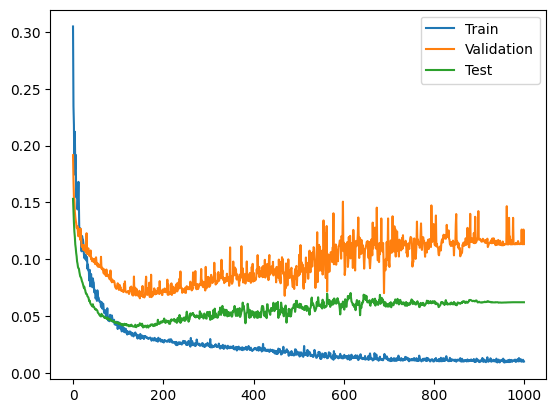

In [12]:
fig, ax = plt.subplots()

ax.plot(training.results['Train'], label='Train')
ax.plot(training.results['Validation'], label='Validation')
ax.plot(training.results['Test'], label='Test')
ax.legend()

## Evaluation and plotting classes

In [13]:
class OSAEvaluator:
    
    def evaluate_OSA(self, dataset, model):
        
        torch.cuda.empty_cache()
        Y_real = []
        Y_pred = []
        for i, data in enumerate(tqdm(dataset)):
            src, tgt, y_real = data
            src, tgt, y_real = src.to(device), tgt.to(device), y_real.to(device)
            y_pred = model(src, tgt)
            Y_real.append(y_real.reshape(1,-1))
            Y_pred.append(y_pred)
        
        Y_real = torch.vstack(Y_real).cpu()
        Y_pred = torch.vstack(Y_pred).cpu().detach()
        print('********** OSA Evaluation summary **********')
        print(f'OSA MSE: {mean_squared_error(Y_real, Y_pred)}')
        print(f'OSA RMSE: {np.sqrt(mean_squared_error(Y_real, Y_pred))}')
        print(f'OSA R2 score: {r2_score(Y_real, Y_pred)}')
        print('********************************************')
        return Y_real, Y_pred
            
class FSEvaluator:
    
    def evaluate_FS(self, dataset, model):
        
        torch.cuda.empty_cache()
        Y_real = []
        Y_pred = []
        tgt_sim = None
        for i, data in enumerate(tqdm(dataset)):
            src, tgt, y_real = data
            src, tgt, y_real = src.to(device), tgt.to(device), y_real.to(device)
            if tgt_sim is None:
                tgt_sim = tgt
            else:
                tgt_sim[:-1,:] = tgt_sim[1:,:]
                tgt_sim[-1,:] = y_pred
            y_pred = model(src, tgt_sim)
            Y_real.append(y_real.reshape(1,-1))
            Y_pred.append(y_pred)
        
        Y_real = torch.vstack(Y_real).cpu()
        Y_pred = torch.vstack(Y_pred).cpu().detach()
        print('*********** FS Evaluation summary **********')
        print(f'FS MSE: {mean_squared_error(Y_real, Y_pred)}')
        print(f'FS RMSE: {np.sqrt(mean_squared_error(Y_real, Y_pred))}')
        print(f'FS R2 score: {r2_score(Y_real, Y_pred)}')
        print('********************************************')
        return Y_real, Y_pred
    
class Evaluator(OSAEvaluator, FSEvaluator):
    
    pass
        

In [14]:
evaluator = Evaluator()
Y_real, Y_pred_OSA = evaluator.evaluate_OSA(dataset, model)
Y_real, Y_pred_FS = evaluator.evaluate_FS(dataset, model)

100%|██████████| 707/707 [00:02<00:00, 240.77it/s]


********** OSA Evaluation summary **********
OSA MSE: 0.03516137972474098
OSA RMSE: 0.18751367926597595
OSA R2 score: 0.796975846317226
********************************************


100%|██████████| 707/707 [00:02<00:00, 264.24it/s]

*********** FS Evaluation summary **********
FS MSE: 0.169447124004364
FS RMSE: 0.411639541387558
FS R2 score: 0.021601032114935914
********************************************


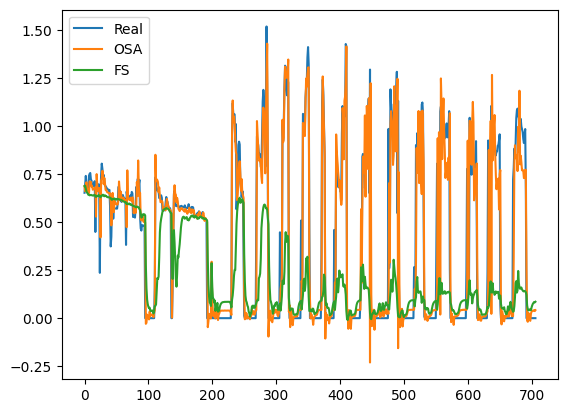

In [15]:
fig, ax = plt.subplots()
ax.plot(Y_real, label='Real')
ax.plot(Y_pred_OSA, label='OSA')
ax.plot(Y_pred_FS, label='FS')
ax.legend()

In [16]:
evaluator = Evaluator()
Y_real, Y_pred_OSA = evaluator.evaluate_OSA(dataset, best_model)
Y_real, Y_pred_FS = evaluator.evaluate_FS(dataset, best_model)

100%|██████████| 707/707 [00:02<00:00, 246.25it/s]


********** OSA Evaluation summary **********
OSA MSE: 0.036734409630298615
OSA RMSE: 0.19166222214698792
OSA R2 score: 0.7878930813693972
********************************************


100%|██████████| 707/707 [00:02<00:00, 275.98it/s]

*********** FS Evaluation summary **********
FS MSE: 0.19263237714767456
FS RMSE: 0.43889904022216797
FS R2 score: -0.11227206857279826
********************************************


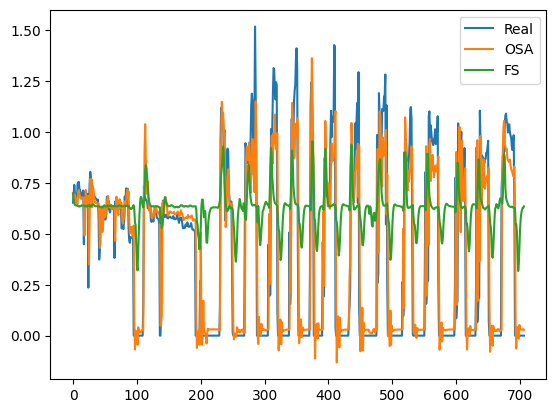

In [17]:
fig, ax = plt.subplots()
ax.plot(Y_real, label='Real')
ax.plot(Y_pred_OSA, label='OSA')
ax.plot(Y_pred_FS, label='FS')
ax.legend()